In [3]:
import pandas as pd
from google.colab import drive
from datetime import datetime
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
from nltk.util import ngrams
import transformers
from datetime import datetime
import json
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
#import spacy

drive.mount('/content/drive')
ts= datetime.now().strftime('%Y-%m-%d_%H-%M')
output_dir = f'/content/drive/My Drive/Colab Notebooks/output/{ts}'
os.makedirs(f"{output_dir}",exist_ok=True)

!pip install pyLDAvis
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [4]:
## loading df that has data for the specific periods of interest     ('2020-01-01', '2020-05-31'),('2020-10-01', '2021-01-31'),('2021-11-01', '2022-01-31'),('2022-11-01','2023-01-31')

In [5]:
# Specify the path including the folder in your Google Drive
path = '/content/drive/My Drive/Colab Notebooks/selected_df.csv'
# Load the DataFrame from the CSV file
df = pd.read_csv(path)

In [6]:
df.head()

,created_utc,label,score,cleaned_text
0,2020-05-31,mild neu,0.569819,ill pay mosaic much
1,2020-05-31,mild neu,0.617377,redemption november right riding shoe either m...
2,2020-05-31,mild neu,0.610706,sure planning hilton redemption soon wouldnt s...
3,2020-05-31,mild neu,0.576460,thanks
4,2020-05-31,mild neu,0.629136,bigger w


In [7]:
!pip install contractions

In [8]:
# import nltk
# nltk.download('punkt_tab')
!pip install -U spacy torch transformers

  Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.6-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.0 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.7.0 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
tsfresh 0.21.0 re

In [10]:
df.shape[0]

87034

In [11]:
#drop NA
# drop any rows where cleaned_text isn’t a real string
df = df.dropna(subset=['cleaned_text'])
df.shape[0]

86446

In [12]:
## Data Cleaning with spaCy
import re, string
import pandas as pd
import contractions
import spacy


nlp = spacy.load("en_core_web_sm")
# nlp = spacy.load("en_core_web_trf")
# Convert timestamp column
df['created_utc'] = pd.to_datetime(df['created_utc'])

# Define full-clean function using spaCy
def full_clean_spacy(doc):
    # Basic regex cleaning
    doc = re.sub(r'\s+', ' ', doc).strip()
    doc = doc.lower()
    doc = re.sub(r'http\S+|www\.\S+', '', doc)
    doc = re.sub(r'<.*?>',          '', doc)
    doc = re.sub(r'@\w+|#\w+',      '', doc)
    doc = contractions.fix(doc)
    doc = doc.translate(str.maketrans('', '', string.punctuation))
    doc = re.sub(r'\d+', '', doc)

    # Process with spaCy
    spacy_doc = nlp(doc)

    # Lemmatize, remove stopwords and short tokens
    tokens = [
        token.lemma_
        for token in spacy_doc
        if not token.is_stop and not token.is_punct and len(token) > 2
    ]
    return tokens

# Apply to each row
df['tokens']     = df['cleaned_text'].apply(full_clean_spacy)
df['final_text'] = df['tokens'].str.join(' ')

# Preview
df[['created_utc','score','final_text','tokens']].head()


,created_utc,score,final_text,tokens
0,2020-05-31,0.569819,ill pay mosaic,"[ill, pay, mosaic]"
1,2020-05-31,0.617377,redemption november right riding shoe move tri...,"[redemption, november, right, riding, shoe, mo..."
2,2020-05-31,0.610706,sure plan hilton redemption soon speculatively...,"[sure, plan, hilton, redemption, soon, specula..."
3,2020-05-31,0.576460,thank,[thank]
4,2020-05-31,0.629136,big,[big]


In [13]:
df.shape[0]

86446

In [ ]:
# Filter the DataFrame
high_pos_df = df[df['label'] == 'high pos']

# Convert the 'created_utc' column to datetime
high_pos_df['created_utc'] = pd.to_datetime(high_pos_df['created_utc'])

# Define your date range
start_date = '2020-01-01'
end_date = '2020-05-31'

# Filter the DataFrame for entries within the specified date range
high_pos_df = high_pos_df[(high_pos_df['created_utc'] >= start_date) & (high_pos_df['created_utc'] <= end_date)]


# Print the filtered DataFrame to check the result
high_pos_df.head()

<ipython-input-12-9996aa23c0e3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_pos_df['created_utc'] = pd.to_datetime(high_pos_df['created_utc'])


,created_utc,label,score,cleaned_text,tokens,final_text
13,2020-05-31,high pos,0.785792,ventana big sur suite night available book onl...,"[ventana, big, sur, suite, night, available, b...",ventana big sur suite night available book onl...
14,2020-05-31,high pos,0.899719,gotchya thanks much advice help,"[gotchya, thank, advice, help]",gotchya thank advice help
16,2020-05-31,high pos,0.905684,dont think difference big enough change plan t...,"[think, difference, big, change, plan, whichev...",think difference big change plan whichever rou...
21,2020-05-31,high pos,0.902608,excellent post ever update japan guide definit...,"[excellent, post, update, japan, guide, defini...",excellent post update japan guide definitely h...
44,2020-05-30,high pos,0.886782,able confirm agent thank much,"[able, confirm, agent, thank]",able confirm agent thank


In [ ]:
high_pos_df.shape[0]

3020

     token  count
0     good    976
1    thank    736
2    great    641
3   flight    530
4     time    439
5     like    403
6     look    402
7    point    392
8     trip    374
9     stay    372
10    book    358
11    nice    353
12     get    329
13     day    322
14   hotel    321
15    well    309
16      go    304
17     fly    298
18   think    285
19   night    274
20  pretty    270
21    year    240
22     way    238
23    find    213
24  travel    212
25   hyatt    207
26    love    204
27    want    198
28    mile    192
29    room    192


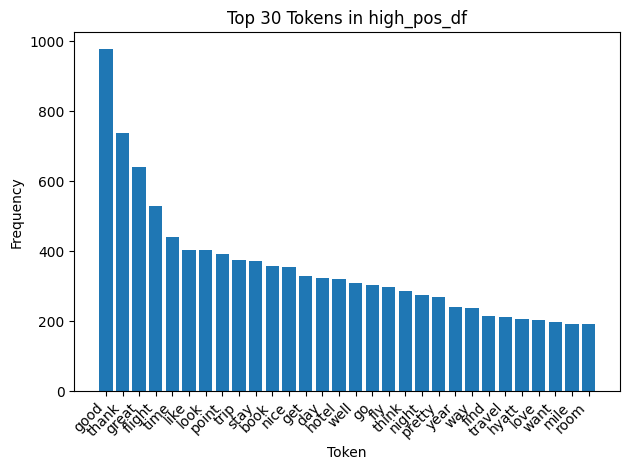

In [ ]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

#Flatten your tokens into one long list
all_tokens = [t for toks in high_pos_df['tokens'] for t in toks]

#Build a frequency distribution
freq = Counter(all_tokens)
common = freq.most_common(30)   # top 30

#Turn it into a DataFrame for easy inspection
df_freq = pd.DataFrame(common, columns=['token','count'])
print(df_freq)

# 4) Plot a simple bar chart of the top tokens
tokens, counts = zip(*common)
plt.figure()
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 30 Tokens in high_pos_df')
plt.tight_layout()
plt.show()

In [ ]:
# Flatten all tokens into one list
all_words   = [word for tokens in high_pos_df['tokens'] for word in tokens]

# Compute the length (in tokens) of each post
post_length = [len(tokens) for tokens in high_pos_df['tokens']]

# Build the vocabulary
vocab       = sorted(set(all_words))

# Print your summary stats
print(f"{len(all_words)} words total, with a vocabulary size of {len(vocab)}")
print(f"Max reddit post length is {max(post_length)} tokens")
print(f"Mean reddit post length is {sum(post_length)/len(post_length):.2f} tokens")
print(f"Median reddit post length is {sorted(post_length)[len(post_length)//2]} tokens")


50864 words total, with a vocabulary size of 6113
Max reddit post length is 246 tokens
Mean reddit post length is 16.84 tokens
Median reddit post length is 11 tokens


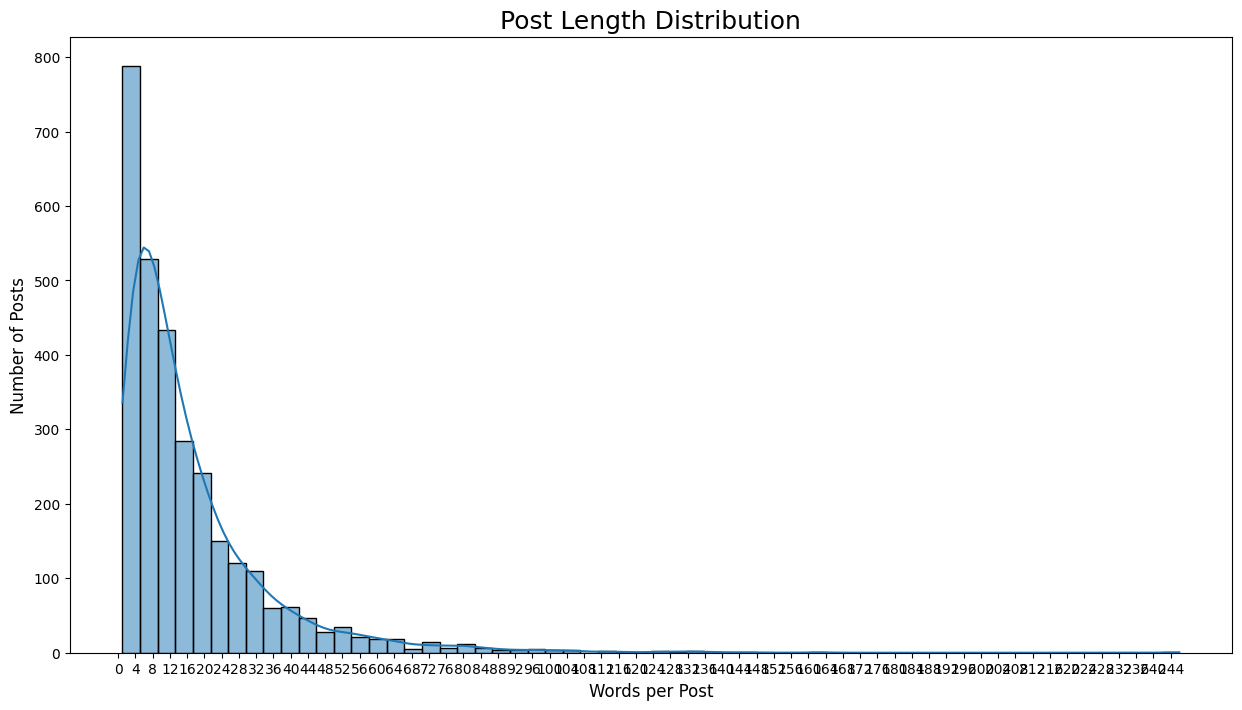

In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
#
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)
plt.xticks(xticks)
plt.show()

In [ ]:

#1) Downgrade NumPy to 1.26.x
# !pip install numpy==1.26.0 --upgrade

# # 2) Force-reinstall Gensim so it compiles against the new NumPy
# !pip install --upgrade --force-reinstall gensim

!pip install  gensim


  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.0 which is incompatible.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.7.0 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


In [ ]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# 1) Prepare your list-of-lists from the `tokens` column
texts = high_pos_df['tokens'].tolist()

#    min_count=3 → only consider pairs that appear in ≥3 docs
#    threshold=50 → higher threshold = fewer, more confident bigrams
# 2) Train the bigram detector
bigram = Phrases(texts, min_count=3, threshold=50)
bigram_mod = Phraser(bigram)

# 3) Train the trigram detector on the bigram-transformed texts
trigram = Phrases(bigram[texts], min_count=2, threshold=150)
trigram_mod = Phraser(trigram)

# 4) Apply bigram and trigram transforms
high_pos_df['bigram_tokens']   = high_pos_df['tokens'].apply(lambda doc: bigram_mod[doc])
high_pos_df['trigram_tokens']  = high_pos_df['tokens'].apply(lambda doc: trigram_mod[bigram_mod[doc]])

# # 5) (Optional) If you need back a single string for vectorizers:
# high_pos_df['bigram_text']   = high_pos_df['bigram_tokens'].str.join(' ')
# high_pos_df['trigram_text']  = high_pos_df['trigram_tokens'].str.join(' ')

# 6) Inspect
print(high_pos_df[['tokens','bigram_tokens','trigram_tokens']].head())


                                               tokens  \
13  [ventana, big, sur, suite, night, available, b...   
14                     [gotchya, thank, advice, help]   
16  [think, difference, big, change, plan, whichev...   
21  [excellent, post, update, japan, guide, defini...   
44                      [able, confirm, agent, thank]   

                                        bigram_tokens  \
13  [ventana, big, sur, suite, night, available, b...   
14                     [gotchya, thank, advice, help]   
16  [think, difference, big, change, plan, whichev...   
21  [excellent, post, update, japan, guide, defini...   
44                      [able, confirm, agent, thank]   

                                       trigram_tokens  
13  [ventana, big_sur, suite, night, available, bo...  
14                     [gotchya, thank, advice, help]  
16  [think, difference, big, change, plan, whichev...  
21  [excellent, post, update, japan, guide, defini...  
44                      [able, con

In [ ]:
#Helper to detect n-grams in a token list
def contains_ngram(tokenized_list, n):
    return any(len(tok.split('_')) == n for tok in tokenized_list)

#Flag rows
high_pos_df['has_bigrams']  = high_pos_df['bigram_tokens'].apply(lambda doc: contains_ngram(doc, 2))
high_pos_df['has_trigrams'] = high_pos_df['trigram_tokens'].apply(lambda doc: contains_ngram(doc, 3))

#Count
rows_with_bigrams  = high_pos_df['has_bigrams'].sum()
rows_with_trigrams = high_pos_df['has_trigrams'].sum()
rows_with_none     = (~high_pos_df['has_bigrams'] & ~high_pos_df['has_trigrams']).sum()


print(f"Rows with bigrams:   {rows_with_bigrams}")
print(f"Rows with trigrams:  {rows_with_trigrams}")
print(f"Rows with no n-grams: {rows_with_none}")


Rows with bigrams:   729
Rows with trigrams:  18
Rows with no n-grams: 2291


In [ ]:
high_pos_df.head()

,created_utc,label,score,cleaned_text,tokens,final_text,bigram_tokens,trigram_tokens,has_bigrams,has_trigrams
13,2020-05-31,high pos,0.785792,ventana big sur suite night available book onl...,"[ventana, big, sur, suite, night, available, b...",ventana big sur suite night available book onl...,"[ventana, big, sur, suite, night, available, b...","[ventana, big_sur, suite, night, available, bo...",False,False
14,2020-05-31,high pos,0.899719,gotchya thanks much advice help,"[gotchya, thank, advice, help]",gotchya thank advice help,"[gotchya, thank, advice, help]","[gotchya, thank, advice, help]",False,False
16,2020-05-31,high pos,0.905684,dont think difference big enough change plan t...,"[think, difference, big, change, plan, whichev...",think difference big change plan whichever rou...,"[think, difference, big, change, plan, whichev...","[think, difference, big, change, plan, whichev...",True,False
21,2020-05-31,high pos,0.902608,excellent post ever update japan guide definit...,"[excellent, post, update, japan, guide, defini...",excellent post update japan guide definitely h...,"[excellent, post, update, japan, guide, defini...","[excellent, post, update, japan, guide, defini...",True,False
44,2020-05-30,high pos,0.886782,able confirm agent thank much,"[able, confirm, agent, thank]",able confirm agent thank,"[able, confirm, agent, thank]","[able, confirm, agent, thank]",False,False


In [ ]:
# Print the total number of rows in the DataFrame
total_rows = high_pos_df.shape[0]
print(f"Total number of rows in the DataFrame: {total_rows}")

# Check the number of rows in the 'trigram_tokenized' column
print(f"Number of rows in 'trigram_tokenized' column: {high_pos_df['trigram_tokens'].shape[0]}")

Total number of rows in the DataFrame: 3020
Number of rows in 'trigram_tokenized' column: 3020


In [ ]:
import itertools
from collections import Counter

#Flatten all trigram lists into one big sequence
all_bigrams = itertools.chain.from_iterable(high_pos_df['bigram_tokens'])

#
bigram_counts = Counter(
    token for token in all_bigrams
    if isinstance(token, str) and token.count('_') == 1
)

#How many unique trigrams?
total_unique_bigrams = len(bigram_counts)
print(f"Total number of unique bigrams: {total_unique_bigrams}")

#Show the 10 most common trigrams
print("\nMost common bigrams:")
for bigram, count in bigram_counts.most_common(10):
    print(f"{bigram}: {count:,}")


Total number of unique bigrams: 126

Most common bigrams:
business_class: 50
highly_recommend: 43
park_hyatt: 41
round_trip: 34
year_ago: 30
credit_card: 26
look_forward: 25
grand_hyatt: 18
super_helpful: 17
let_know: 17


In [ ]:
import itertools
from collections import Counter

# Flatten all trigram lists into one big sequence
all_trigrams = itertools.chain.from_iterable(high_pos_df['trigram_tokens'])

#Filter for genuine trigrams (exactly two underscores → three words joined)
trigram_counts = Counter(
    token for token in all_trigrams
    if isinstance(token, str) and token.count('_') == 2
)

#How many unique trigrams?
total_unique_trigrams = len(trigram_counts)
print(f"Total number of unique trigrams: {total_unique_trigrams}")

#Show the 10 most common trigrams
print("\nMost common trigrams:")
for trigram, count in trigram_counts.most_common(10):
    print(f"{trigram}: {count:,}")


Total number of unique trigrams: 5

Most common trigrams:
playa_del_carmen: 5
star_alliance_partner: 5
round_trip_ticket: 3
grand_hyatt_kauai: 3
residence_inn_kensington: 3


In [ ]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(high_pos_df['trigram_tokens'].tolist())

# ## pruning
# #id2word.filter_extremes(no_below=5, no_above=0.5)

# #    (Optional) Re-map the remaining token IDs to remove gaps
# #id2word.compactify()

# # 2. Convert each document to a Bag-of-Words
# texts = high_pos_df['trigram_tokens'].tolist()

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # View
# print(corpus[:1][0][:30])

In [ ]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# ## Build the basic LDA model
# lda_model = LdaModel(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=4,
#                                        random_state=100,
#                                        chunksize=250,
#                                        passes=200,
#                                         iterations= 100,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)

In [ ]:
# from pprint import pprint

# # Print the Keyword in the 3 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [ ]:
# from gensim.models import CoherenceModel
# #
# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=high_pos_df['trigram_tokenized'], dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('Coherence Score: ', coherence_lda)

In [ ]:
# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# #
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)

In [ ]:
# # Extracting and printing the top 30 salient terms for each topic
# num_topics = lda_model.num_topics
# num_words = 30

# for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
#     print(f"Topic {idx + 1}:")
#     for word, weight in topic:
#         print(f"  {word} ({weight:.4f})")
#     print()

In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools

#
texts = high_pos_df['trigram_tokens'].tolist()

# Create a Dictionary and Corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations,seed):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=seed,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
     # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
seeds = [0, 1, 2]
num_topics_range = range(2, 10)  # Adjust the range based on your needs
chunksize_range = [1000]
passes_range = [100, 200,260]
iterations_range = [50, 100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for seed in [0, 1, 2]:
  for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence, alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence, alpha, eta, seed))
    # print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}"  f"Alpha: {alpha}, Eta: {eta}")

print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, "
      f"Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta','seed'])
# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])


# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']
optimal_seed = optimal_result['seed']



print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")
print(f" seed:  {optimal_seed}")

Num Topics: 9, Chunksize: 1000, Passes: 260, Iterations: 200, Perplexity: -7.6441, Coherence: 0.4954, Alpha: [0.22372927 0.10459667 0.34670854 0.12095872 0.38778242 0.07770087
 1.065705   0.2642118  0.18341807], Eta: [0.12684155 0.10744235 0.10628752 ... 0.10625882 0.10625882 0.10625882]

Results:
     num_topics  chunksize  passes  iterations  perplexity  coherence  \
0             2       1000     100          50   -7.433942   0.409577   
1             2       1000     100         100   -7.433537   0.410073   
2             2       1000     100         200   -7.432998   0.410073   
3             2       1000     200          50   -7.429143   0.409577   
4             2       1000     200         100   -7.428866   0.410073   
..          ...        ...     ...         ...         ...        ...   
211           9       1000     200         100   -7.656482   0.451275   
212           9       1000     200         200   -7.646615   0.491420   
213           9       1000     260          

In [ ]:
#Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = optimal_seed,
    per_word_topics=True
)

#Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


Re-fitted Optimal Model:
 Coherence: 0.6039
 Perplexity: -7.3558
 Alpha (per topic): [0.0496531  0.10692371]
 Eta   (per word):  [11.888199   7.67461    3.5543246 ...  0.9464534  0.9464534  0.9464534]


In [ ]:
import numpy as np
from google.colab import files

#
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

#Write them into a single text file
with open('lda_model_full_summary.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")

#Trigger the download
files.download('lda_model_full_summary.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


Alpha match: True
Eta   match: True


In [ ]:
#Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

#Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



=== Topics ===
[(0,
  '0.012*"stay" + 0.011*"great" + 0.011*"hotel" + 0.009*"good" + 0.009*"night" '
  '+ 0.009*"time" + 0.008*"nice" + 0.007*"like" + 0.007*"day" + 0.006*"room"'),
 (1,
  '0.029*"good" + 0.024*"thank" + 0.016*"flight" + 0.011*"great" + 0.010*"go" '
  '+ 0.010*"fly" + 0.009*"book" + 0.009*"trip" + 0.008*"week" + 0.008*"like"')]

Sample doc-topic distribution for doc 0:
[(0, 0.45864633), (1, 0.54135364)]


In [ ]:
# pyLDAvis visualization
pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [ ]:
#Print the top 30 terms per topic
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  stay (0.0123)
  great (0.0115)
  hotel (0.0109)
  good (0.0094)
  night (0.0093)
  time (0.0087)
  nice (0.0081)
  like (0.0072)
  day (0.0071)
  room (0.0065)
  point (0.0061)
  look (0.0058)
  trip (0.0053)
  food (0.0053)
  love (0.0052)
  think (0.0050)
  get (0.0048)
  place (0.0048)
  amazing (0.0047)
  want (0.0047)
  hyatt (0.0047)
  go (0.0046)
  beach (0.0046)
  appreciate (0.0046)
  free (0.0042)
  well (0.0042)
  upgrade (0.0042)
  resort (0.0042)
  pretty (0.0041)
  hilton (0.0040)

Topic 2:
  good (0.0287)
  thank (0.0238)
  flight (0.0162)
  great (0.0109)
  go (0.0102)
  fly (0.0100)
  book (0.0095)
  trip (0.0088)
  week (0.0081)
  like (0.0079)
  point (0.0070)
  think (0.0065)
  travel (0.0064)
  well (0.0063)
  time (0.0062)
  luck (0.0058)
  way (0.0057)
  bit (0.0056)
  definitely (0.0055)
  look (0.0054)
  october (0.0050)
  yeah (0.0049)
  get (0.0049)
  september (0.0049)
  mile (0.0047)
  hot (0.0046)
  europe (0.0045

In [ ]:
import gensim.corpora as corpora
# # Create Dictionary
id2word = corpora.Dictionary(high_pos_df['trigram_tokens'].tolist())

# ## pruning
id2word.filter_extremes(no_below=5, no_above=0.7)

# #
id2word.compactify()

# Convert each document to a Bag-of-Words
texts = high_pos_df['trigram_tokens'].tolist()

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 2)]


In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools


# Create a Dictionary and Corpus
dictionary = id2word


# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=100,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
     # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
num_topics_range = range(2, 10)  # Adjust the range based on your needs
chunksize_range = [250]
passes_range = [100, 200,260]
iterations_range = [50, 100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence, alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence, alpha, eta))
    # print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}"  f"Alpha: {alpha}, Eta: {eta}")

print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, "
      f"Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta'])
# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])


# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']


print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")

Num Topics: 9, Chunksize: 250, Passes: 260, Iterations: 200, Perplexity: -6.5959, Coherence: 0.4983, Alpha: [0.49914277 1.1220796  2.0211322  0.81822413 0.59502536 0.7848896
 0.9272437  0.7949959  8.031407  ], Eta: [0.09535202 0.09533893 0.0944371  ... 0.09247686 0.09216136 0.09233217]

Results:
    num_topics  chunksize  passes  iterations  perplexity  coherence  \
0            2        250     100          50   -6.463404   0.622733   
1            2        250     100         100   -6.463233   0.622733   
2            2        250     100         200   -6.463185   0.622733   
3            2        250     200          50   -6.455316   0.651617   
4            2        250     200         100   -6.455176   0.651617   
..         ...        ...     ...         ...         ...        ...   
67           9        250     200         100   -6.596164   0.468190   
68           9        250     200         200   -6.597430   0.499084   
69           9        250     260          50   -6.5945

In [ ]:
#  Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = 100,
    per_word_topics=True
)

# Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


Re-fitted Optimal Model:
 Coherence: 0.6516
 Perplexity: -6.4530
 Alpha (per topic): [0.223856   0.09334305]
 Eta   (per word):  [3.0530083  1.8298622  1.3245242  ... 0.3822503  0.37861544 0.37799373]


In [ ]:
import numpy as np
from google.colab import files

#
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

#  Write them into a single text file
with open('lda_model_full_summary.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")

# Trigger the download
files.download('lda_model_full_summary.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Cell 3: verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


Alpha match: True
Eta   match: True


In [ ]:
# Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



=== Topics ===
[(0,
  '0.034*"good" + 0.030*"thank" + 0.021*"flight" + 0.014*"great" + '
  '0.012*"book" + 0.012*"fly" + 0.010*"point" + 0.009*"like" + 0.009*"look" + '
  '0.009*"get"'),
 (1,
  '0.019*"stay" + 0.017*"hotel" + 0.015*"great" + 0.015*"night" + 0.013*"time" '
  '+ 0.012*"nice" + 0.011*"good" + 0.010*"go" + 0.010*"room" + 0.010*"day"')]

Sample doc-topic distribution for doc 0:
[(0, 0.5166732), (1, 0.48332682)]


In [ ]:
#  pyLDAvis visualization
#
pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [ ]:
#  Print the top 30 terms per topic
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  good (0.0338)
  thank (0.0298)
  flight (0.0213)
  great (0.0144)
  book (0.0125)
  fly (0.0120)
  point (0.0100)
  like (0.0095)
  look (0.0089)
  get (0.0087)
  time (0.0077)
  trip (0.0073)
  well (0.0073)
  way (0.0072)
  pretty (0.0066)
  go (0.0065)
  airline (0.0065)
  mile (0.0065)
  think (0.0065)
  travel (0.0064)
  work (0.0060)
  find (0.0060)
  appreciate (0.0058)
  awesome (0.0058)
  nice (0.0052)
  know (0.0052)
  day (0.0051)
  help (0.0049)
  cheap (0.0048)
  luck (0.0048)

Topic 2:
  stay (0.0194)
  hotel (0.0170)
  great (0.0151)
  night (0.0145)
  time (0.0134)
  nice (0.0122)
  good (0.0107)
  go (0.0105)
  room (0.0101)
  day (0.0098)
  like (0.0096)
  trip (0.0090)
  food (0.0087)
  place (0.0076)
  think (0.0076)
  beach (0.0072)
  hyatt (0.0071)
  amazing (0.0070)
  look (0.0069)
  point (0.0067)
  well (0.0065)
  resort (0.0065)
  love (0.0063)
  property (0.0063)
  free (0.0061)
  want (0.0061)
  hilton (0.0061)
  ma

In [ ]:
####### HIGH NEGATIVE FOR FIRST COVID WAVE ########
# Filter the DataFrame
high_neg_first_wave_df = df[df['label'] == 'high neg']

# Convert the 'created_utc' column to datetime
high_neg_first_wave_df['created_utc'] = pd.to_datetime(high_neg_first_wave_df['created_utc'])

# Define your date range
start_date = '2020-01-01'
end_date = '2020-05-31'

# Filter the DataFrame for entries within the specified date range
high_neg_first_wave_df = high_neg_first_wave_df[(high_neg_first_wave_df['created_utc'] >= start_date) & (high_neg_first_wave_df['created_utc'] <= end_date)]


# Print the filtered DataFrame to check the result
high_neg_first_wave_df.head()

<ipython-input-45-8c30d5c13a9d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_neg_first_wave_df['created_utc'] = pd.to_datetime(high_neg_first_wave_df['created_utc'])


,created_utc,label,score,cleaned_text,tokens,final_text
38,2020-05-30,high neg,0.848009,wow cant take gf ana point somehow always over...,"[wow, ana, point, overlook, rule]",wow ana point overlook rule
94,2020-05-29,high neg,0.936842,look like gross,"[look, like, gross]",look like gross
98,2020-05-29,high neg,0.952978,idiot,[idiot],idiot
178,2020-05-28,high neg,0.823201,well right cant anything flying club database ...,"[right, fly, club, database, inaccessible, day...",right fly club database inaccessible day login...
241,2020-05-27,high neg,0.801195,youd surprised dumb people desperate escape,"[surprised, dumb, people, desperate, escape]",surprised dumb people desperate escape


In [ ]:
high_neg_first_wave_df.shape[0]

1537

      token  count
0    flight    413
1   airline    292
2    cancel    285
3    people    281
4      like    227
5       bad    223
6    refund    196
7    travel    193
8      time    182
9        go    172
10      get    165
11    point    143
12      try    137
13     book    133
14    thing    123
15   ticket    121
16     know    117
17      fly    113
18      day    112
19     fuck    107
20    think    107
21     want    106
22      pay    105
23     work    102
24    right    101
25     suck     96
26   credit     90
27      say     89
28      way     85
29     hour     83


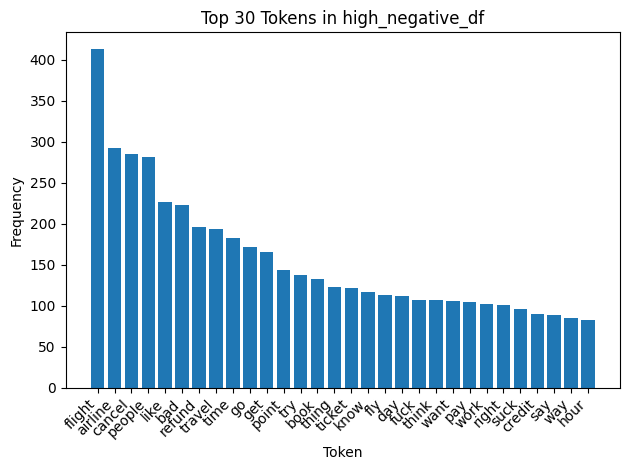

In [ ]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Flatten your tokens into one long list
all_tokens = [t for toks in high_neg_first_wave_df['tokens'] for t in toks]

#  Build a frequency distribution
freq = Counter(all_tokens)
common = freq.most_common(30)   # top 30

#  Turn it into a DataFrame for easy inspection
df_freq = pd.DataFrame(common, columns=['token','count'])
print(df_freq)

#  Plot a simple bar chart of the top tokens
tokens, counts = zip(*common)
plt.figure()
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 30 Tokens in high_negative_df')
plt.tight_layout()
plt.show()

In [ ]:
# Flatten all tokens into one list
all_words   = [word for tokens in high_neg_first_wave_df['tokens'] for word in tokens]

# Compute the length (in tokens) of each post
post_length = [len(tokens) for tokens in high_neg_first_wave_df['tokens']]

# Build the vocabulary
vocab       = sorted(set(all_words))

# Print your summary stats
print(f"{len(all_words)} words total, with a vocabulary size of {len(vocab)}")
print(f"Max reddit post length is {max(post_length)} tokens")
print(f"Mean reddit post length is {sum(post_length)/len(post_length):.2f} tokens")
print(f"Median reddit post length is {sorted(post_length)[len(post_length)//2]} tokens")


24102 words total, with a vocabulary size of 4278
Max reddit post length is 142 tokens
Mean reddit post length is 15.68 tokens
Median reddit post length is 11 tokens


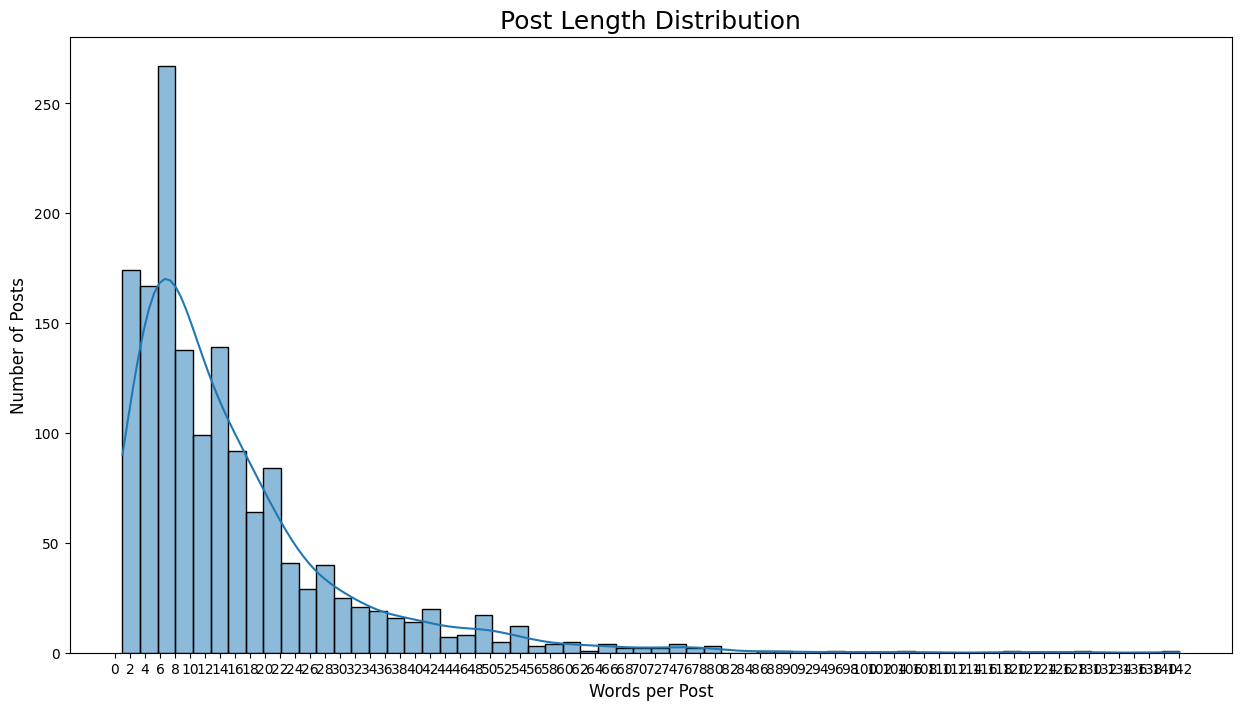

In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)
plt.xticks(xticks)
plt.show()

In [ ]:
#!pip install  gensim


In [ ]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

#  Prepare your list-of-lists from the `tokens` column
texts = high_neg_first_wave_df['tokens'].tolist()

# Train the bigram detector
bigram = Phrases(texts, min_count=3, threshold=60)
bigram_mod = Phraser(bigram)

#  Train the trigram detector on the bigram-transformed texts
trigram = Phrases(bigram[texts], min_count=2, threshold=150)
trigram_mod = Phraser(trigram)

#  Apply bigram and trigram transforms
high_neg_first_wave_df['bigram_tokens']   = high_neg_first_wave_df['tokens'].apply(lambda doc: bigram_mod[doc])
high_neg_first_wave_df['trigram_tokens']  = high_neg_first_wave_df['tokens'].apply(lambda doc: trigram_mod[bigram_mod[doc]])

# #
# high_neg_first_wave_df['bigram_text']   = high_neg_first_wave_df['bigram_tokens'].str.join(' ')
# high_neg_first_wave_df['trigram_text']  = high_neg_first_wave_df['trigram_tokens'].str.join(' ')

#  Inspect
print(high_neg_first_wave_df[['tokens','bigram_tokens','trigram_tokens']].head())


                                                tokens  \
38                   [wow, ana, point, overlook, rule]   
94                                 [look, like, gross]   
98                                             [idiot]   
178  [right, fly, club, database, inaccessible, day...   
241       [surprised, dumb, people, desperate, escape]   

                                         bigram_tokens  \
38                   [wow, ana, point, overlook, rule]   
94                                 [look, like, gross]   
98                                             [idiot]   
178  [right, fly, club, database, inaccessible, day...   
241       [surprised, dumb, people, desperate, escape]   

                                        trigram_tokens  
38                   [wow, ana, point, overlook, rule]  
94                                 [look, like, gross]  
98                                             [idiot]  
178  [right, fly, club, database, inaccessible, day...  
241       [surpri

In [ ]:
# 1) Helper to detect n-grams in a token list
def contains_ngram(tokenized_list, n):
    return any(len(tok.split('_')) == n for tok in tokenized_list)

# 2) Flag rows
high_neg_first_wave_df['has_bigrams']  = high_neg_first_wave_df['bigram_tokens'].apply(lambda doc: contains_ngram(doc, 2))
high_neg_first_wave_df['has_trigrams'] = high_neg_first_wave_df['trigram_tokens'].apply(lambda doc: contains_ngram(doc, 3))

# 3) Count
rows_with_bigrams  = high_neg_first_wave_df['has_bigrams'].sum()
rows_with_trigrams = high_neg_first_wave_df['has_trigrams'].sum()
rows_with_none     = (~high_neg_first_wave_df['has_bigrams'] & ~high_neg_first_wave_df['has_trigrams']).sum()

# 4) Report
print(f"Rows with bigrams:   {rows_with_bigrams}")
print(f"Rows with trigrams:  {rows_with_trigrams}")
print(f"Rows with no n-grams: {rows_with_none}")


Rows with bigrams:   167
Rows with trigrams:  9
Rows with no n-grams: 1370


In [ ]:
high_neg_first_wave_df.head()

,created_utc,label,score,cleaned_text,tokens,final_text,bigram_tokens,trigram_tokens,has_bigrams,has_trigrams
38,2020-05-30,high neg,0.848009,wow cant take gf ana point somehow always over...,"[wow, ana, point, overlook, rule]",wow ana point overlook rule,"[wow, ana, point, overlook, rule]","[wow, ana, point, overlook, rule]",False,False
94,2020-05-29,high neg,0.936842,look like gross,"[look, like, gross]",look like gross,"[look, like, gross]","[look, like, gross]",False,False
98,2020-05-29,high neg,0.952978,idiot,[idiot],idiot,[idiot],[idiot],False,False
178,2020-05-28,high neg,0.823201,well right cant anything flying club database ...,"[right, fly, club, database, inaccessible, day...",right fly club database inaccessible day login...,"[right, fly, club, database, inaccessible, day...","[right, fly, club, database, inaccessible, day...",False,False
241,2020-05-27,high neg,0.801195,youd surprised dumb people desperate escape,"[surprised, dumb, people, desperate, escape]",surprised dumb people desperate escape,"[surprised, dumb, people, desperate, escape]","[surprised, dumb, people, desperate, escape]",False,False


In [ ]:
# Print the total number of rows in the DataFrame
total_rows = high_neg_first_wave_df.shape[0]
print(f"Total number of rows in the DataFrame: {total_rows}")

# Check the number of rows in the 'trigram_tokenized' column
print(f"Number of rows in 'trigram_tokenized' column: {high_neg_first_wave_df['trigram_tokens'].shape[0]}")

Total number of rows in the DataFrame: 1537
Number of rows in 'trigram_tokenized' column: 1537


In [ ]:
import itertools
from collections import Counter

#  Flatten all trigram lists into one big sequence
all_trigrams = itertools.chain.from_iterable(high_neg_first_wave_df['trigram_tokens'])

#
trigram_counts = Counter(
    token for token in all_trigrams
    if isinstance(token, str) and token.count('_') == 2
)

#  How many unique trigrams?
total_unique_trigrams = len(trigram_counts)
print(f"Total number of unique trigrams: {total_unique_trigrams}")

#  Show the 10 most common trigrams
print("\nMost common trigrams:")
for trigram, count in trigram_counts.most_common(10):
    print(f"{trigram}: {count:,}")


Total number of unique trigrams: 4

Most common trigrams:
purchase_cancellation_insurance: 5
originate_china_cover: 3
submit_request_form: 3
fucking_entitle_consumer: 3


In [ ]:
# import gensim.corpora as corpora
# # Create Dictionary
# id2word = corpora.Dictionary(high_neg_first_wave_df['trigram_tokens'].tolist())

# ## pruning
# #id2word.filter_extremes(no_below=5, no_above=0.5)

# #    (Optional) Re-map the remaining token IDs to remove gaps
# #id2word.compactify()

# # 2. Convert each document to a Bag-of-Words
# texts = high_neg_first_wave_df['trigram_tokens'].tolist()

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # View
# print(corpus[:1][0][:30])

In [ ]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# ## Build the basic LDA model
# lda_model = LdaModel(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=2,
#                                        random_state=100,
#                                           chunksize=250,
#                                        passes=100,
#                                         iterations= 200,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)

In [ ]:
# from pprint import pprint

# # Print the Keyword in the 3 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [ ]:
# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

#
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)

In [ ]:
# # Extracting and printing the top 30 salient terms for each topic
# num_topics = lda_model.num_topics
# num_words = 30

# for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
#     print(f"Topic {idx + 1}:")
#     for word, weight in topic:
#         print(f"  {word} ({weight:.4f})")
#     print()

In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools

#
texts = high_neg_first_wave_df['trigram_tokens'].tolist()

# Create a Dictionary and Corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=seed,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
     # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
num_topics_range = range(2, 10)  # Adjust the range based on your needs
chunksize_range = [300]
passes_range = [100, 200,260]
iterations_range = [50,100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for seed in [0, 1, 2]:
  for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence , alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence,alpha,eta, seed))
    print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta','seed'])

# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']
optimal_seed = optimal_result['seed']

print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")
print(f" seed:  {optimal_seed}")

Num Topics: 2, Chunksize: 300, Passes: 100, Iterations: 50, Perplexity: -7.4666, Coherence: 0.5091, Alpha: [0.03563811 0.07156262], Eta: [ 0.93598896  0.4902953  15.149479   ...  0.6662179   0.6662179
  0.6662177 ]
Num Topics: 2, Chunksize: 300, Passes: 100, Iterations: 100, Perplexity: -7.4887, Coherence: 0.5206, Alpha: [0.09083754 0.06816643], Eta: [ 0.91320795  0.58687794 19.981646   ...  0.6919063   0.6919063
  0.6919059 ]
Num Topics: 2, Chunksize: 300, Passes: 100, Iterations: 200, Perplexity: -7.4777, Coherence: 0.5018, Alpha: [0.12403204 0.04454852], Eta: [ 0.84192514  0.5069285  13.29987    ...  0.66580576  0.66580576
  0.6658055 ]
Num Topics: 2, Chunksize: 300, Passes: 200, Iterations: 50, Perplexity: -7.4503, Coherence: 0.5091, Alpha: [0.02685123 0.05758255], Eta: [ 0.92469466  0.49319497 15.515491   ...  0.671294    0.671294
  0.67129385]
Num Topics: 2, Chunksize: 300, Passes: 200, Iterations: 100, Perplexity: -7.4635, Coherence: 0.5096, Alpha: [0.06124137 0.05224074], Eta: 

In [ ]:
# 1. Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = optimal_seed,
    per_word_topics=True
)

# 2. Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


Re-fitted Optimal Model:
 Coherence: 0.5215
 Perplexity: -7.8265
 Alpha (per topic): [0.2708507  0.22431041 2.2363908  0.35064012 0.40957406 0.29874256
 0.5076035  1.3288394  0.30084795]
 Eta   (per word):  [0.10594191 0.10295783 0.10865391 ... 0.10480348 0.10480348 0.10479999]


In [ ]:
import numpy as np
from google.colab import files

#
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

# 2. Write them into a single text file
with open('lda_model_full_summary.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")

#  Trigger the download
files.download('lda_model_full_summary.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#  verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


Alpha match: True
Eta   match: True


In [ ]:
#  Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



=== Topics ===
[(0,
  '0.033*"passenger" + 0.024*"aircraft" + 0.019*"sound" + 0.017*"emirate" + '
  '0.016*"safety" + 0.012*"worried" + 0.010*"restroom" + 0.010*"down" + '
  '0.010*"worst" + 0.009*"certainly"'),
 (1,
  '0.052*"ban" + 0.032*"missile" + 0.022*"airspace" + 0.019*"shoot" + '
  '0.017*"risk" + 0.016*"defense" + 0.016*"plane" + 0.013*"air" + 0.012*"rain" '
  '+ 0.009*"strike"'),
 (2,
  '0.044*"flight" + 0.031*"airline" + 0.026*"cancel" + 0.022*"bad" + '
  '0.021*"go" + 0.017*"time" + 0.017*"get" + 0.017*"refund" + 0.016*"ticket" + '
  '0.016*"like"'),
 (3,
  '0.020*"threat" + 0.017*"shot" + 0.017*"base" + 0.016*"reason" + '
  '0.015*"year" + 0.013*"assume" + 0.012*"street" + 0.011*"cover" + '
  '0.011*"level" + 0.011*"old"'),
 (4,
  '0.020*"charge" + 0.018*"way" + 0.013*"concern" + 0.012*"usa" + '
  '0.011*"train" + 0.011*"deal" + 0.011*"yeah" + 0.010*"avoid" + 0.010*"big" + '
  '0.010*"new_york"'),
 (5,
  '0.040*"iran" + 0.029*"fee" + 0.023*"head" + 0.021*"air" + 0.019*"ser

In [ ]:
#  pyLDAvis visualization

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [ ]:
#  Print the top 30 terms per topic
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  passenger (0.0330)
  aircraft (0.0238)
  sound (0.0190)
  emirate (0.0168)
  safety (0.0158)
  worried (0.0118)
  restroom (0.0099)
  down (0.0099)
  worst (0.0099)
  certainly (0.0095)
  decide (0.0091)
  room (0.0087)
  bill (0.0085)
  allow (0.0084)
  frustrating (0.0080)
  london (0.0080)
  send (0.0080)
  scare (0.0076)
  lufthansa (0.0070)
  anxiety (0.0066)
  community (0.0063)
  takeoff (0.0061)
  toss (0.0060)
  driver (0.0060)
  insult (0.0060)
  perceive (0.0055)
  infect (0.0055)
  possibly (0.0055)
  personally (0.0055)
  title (0.0055)

Topic 2:
  ban (0.0523)
  missile (0.0325)
  airspace (0.0218)
  shoot (0.0189)
  risk (0.0172)
  defense (0.0163)
  plane (0.0159)
  air (0.0135)
  rain (0.0122)
  strike (0.0090)
  happen (0.0086)
  bird (0.0085)
  fly (0.0083)
  fine (0.0082)
  ice (0.0082)
  bean (0.0082)
  birdstrike (0.0082)
  distract (0.0082)
  fart (0.0082)
  flap (0.0082)
  analogy (0.0082)
  apperently (0.0082)
  water 

In [ ]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(high_neg_first_wave_df['trigram_tokens'].tolist())

## pruning
id2word.filter_extremes(no_below=5, no_above=0.7)

#
id2word.compactify()

# 2. Convert each document to a Bag-of-Words
texts = high_neg_first_wave_df['trigram_tokens'].tolist()

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1)]


In [ ]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools


# Create a Dictionary and Corpus
dictionary = id2word


# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=100,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
     # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
num_topics_range = range(2, 10)  # Adjust the range based on your needs
chunksize_range = [250]
passes_range = [100, 200,260]
iterations_range = [50,100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence , alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence,alpha,eta))
    print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f}, Alpha: {alpha}, Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta'])

# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']

print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")

Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 50, Perplexity: -6.3398, Coherence: 0.5030, Alpha: [0.13127072 0.30943516], Eta: [ 0.4788556   4.5324984   0.48675257  0.44696203  0.38549545 10.008868
  3.376878    0.7580758   0.45648834  1.3707299   0.3896827   4.3150697
  0.6627735   0.44567472  6.251712    4.7974925   2.993965    0.44681376
  0.5782898   0.6095196   0.42594036  5.0158744   3.4026837   1.9253374
  0.39200962  0.6217276  11.495525    1.4862748   0.6217021   0.670977
  0.495573    0.5842576   1.7082568   0.65202546  0.4390775   0.4284546
  0.48436576  0.5725505   0.42081687  1.3148907   1.8122913   0.5882333
  0.5195708   0.7731521   0.47574258  0.5010251   3.9297965   1.8175755
  0.6874698   5.2732034   3.1827664   0.42255062  0.5057484   0.5558689
  0.5547232   1.6459839   0.57103974  0.5674708   2.1336179   2.2564964
  1.3135883   0.44217274  1.2464985   0.5756592   0.42119616  0.47465524
  0.8358478   0.8523776   0.56848484  3.7525396   7.344959    0.6080993

Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 100, Perplexity: -6.3406, Coherence: 0.5113, Alpha: [0.13667685 0.31599206], Eta: [ 0.48109528  4.532749    0.48762798  0.45018816  0.38538516  9.994794
  3.3706656   0.7578577   0.4561321   1.3674002   0.3891927   4.279775
  0.6945287   0.44330975  6.2423773   4.6477056   2.9697661   0.45397946
  0.5777548   0.6081356   0.42564502  5.0073624   3.388904    1.9006971
  0.39161292  0.62939405 11.498105    1.4863267   0.6138355   0.67612416
  0.5059075   0.57109696  1.7014906   0.66457266  0.44336176  0.42777684
  0.48536268  0.5710727   0.41958585  1.3342892   1.8033603   0.5856177
  0.5117798   0.7801826   0.49767816  0.5005812   3.927216    1.8157175
  0.69309914  5.2693152   3.1638079   0.42776445  0.51706356  0.5578267
  0.5542218   1.640725    0.5704604   0.5669722   2.1226199   2.2375288
  1.3118287   0.44153407  1.2457364   0.5699937   0.41783682  0.47329462
  0.8358482   0.9273561   0.5682604   4.1767163   7.3499975   0.6078

Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 200, Perplexity: -6.3429, Coherence: 0.5094, Alpha: [0.13273342 0.31470573], Eta: [ 0.4815155   4.5112596   0.48833522  0.4505646   0.38572887  9.99576
  3.3837862   0.7586016   0.4563798   1.3738838   0.38947034  4.271564
  0.7068295   0.44010597  6.251282    4.4224725   2.9722784   0.48674008
  0.57815826  0.60813624  0.42587057  5.0125074   3.3248854   1.8718923
  0.39181668  0.6286354  11.911585    1.489926    0.6052686   0.68405086
  0.5148124   0.47284222  1.6784173   0.6203137   0.46740627  0.42712942
  0.480654    0.56628686  0.4219938   1.3371862   1.7890495   0.5799847
  0.50345325  0.7879158   0.47893536  0.5008642   3.9385571   1.8209813
  0.67797077  5.227492    3.107152    0.41922587  0.5156141   0.55587506
  0.54665345  1.6369684   0.5717669   0.56724274  2.0709307   2.2246733
  1.3111097   0.43957606  1.2461134   0.563135    0.40739006  0.48889092
  0.8349513   1.1090775   0.5683652   4.2015314   7.267687    0.6078

Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 50, Perplexity: -6.3284, Coherence: 0.4987, Alpha: [0.09898234 0.24223173], Eta: [ 0.489911    4.8582306   0.4974701   0.44603953  0.39216903 10.429115
  3.5335402   0.77858543  0.46564978  1.4159713   0.39698967  4.5618715
  0.67926073  0.47536117  6.545338    4.7364206   3.1061072   0.4629421
  0.5914311   0.6226339   0.43436816  5.261038    3.6505764   2.0545146
  0.39864635  0.6383468  12.441657    1.5090443   0.6196786   0.68706316
  0.49431828  0.62522113  1.7775744   0.99046093  0.43725422  0.43913656
  0.50731474  0.5910683   0.43003604  1.3846118   1.974735    0.60891616
  0.55742157  0.78643227  0.4945868   0.51375467  4.088487    1.8931377
  0.8430155   5.5890393   3.4385207   0.42884934  0.5192033   0.5736692
  0.56862617  1.7006658   0.5829797   0.5798221   2.2439523   2.3836672
  1.3641734   0.44585782  1.2887344   0.6285539   0.43413413  0.50913155
  0.85760146  1.1420995   0.57978785  3.9731443   7.8061166   0.6238

Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 100, Perplexity: -6.3292, Coherence: 0.4987, Alpha: [0.10286625 0.24863456], Eta: [ 0.49137038  4.835106    0.49790806  0.4476649   0.39167154 10.386387
  3.5201976   0.77737606  0.4649256   1.4102979   0.39635912  4.5364213
  0.67527574  0.47401685  6.529207    4.668549    3.0897434   0.46017712
  0.5903902   0.6206882   0.4337361   5.241576    3.6416006   2.036182
  0.39801002  0.65260035 12.3966465   1.5318872   0.6178252   0.6899787
  0.517228    0.6153361   1.7679882   0.98715436  0.43744877  0.43791398
  0.50663674  0.58324367  0.42818666  1.3804816   1.9468069   0.60448873
  0.54415053  0.78778625  0.5104734   0.5129222   4.0771956   1.8889103
  0.9315218   5.566868    3.4162319   0.43973628  0.534855    0.5756202
  0.5693819   1.6844327   0.5818591   0.57855874  2.229136    2.3661735
  1.3606197   0.44341967  1.2884394   0.6201313   0.4290866   0.5040526
  0.85614276  1.139076    0.5788514   4.3409514   7.80454     0.62338

Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 200, Perplexity: -6.3300, Coherence: 0.5164, Alpha: [0.09907009 0.23707967], Eta: [ 0.49326372  4.8537445   0.49975982  0.44902995  0.39268965 10.428816
  3.5403824   0.7805299   0.4660704   1.4169092   0.39734027  4.5602164
  0.6829027   0.4679655   6.5709276   4.652178    3.091677    0.4592507
  0.59211445  0.6219938   0.43476158  5.27183     3.65177     2.024573
  0.3988542   0.67514235 12.563302    1.5389774   0.61916846  0.69447094
  0.5208564   0.58785087  1.7522752   0.99075127  0.43920964  0.43811628
  0.50639033  0.5769904   0.4291625   1.3867625   1.938451    0.6030886
  0.541637    0.7935495   0.506493    0.51470584  4.105379    1.8984262
  0.83027565  5.60594     3.3896859   0.43228045  0.53957844  0.5783347
  0.56688654  1.6964846   0.58366203  0.5800809   2.2150328   2.375677
  1.3667337   0.44463146  1.294058    0.6205096   0.42931628  0.4983487
  0.85942006  1.1441126   0.58076173  4.450275    7.7433476   0.6252923

Num Topics: 2, Chunksize: 250, Passes: 260, Iterations: 50, Perplexity: -6.3258, Coherence: 0.4987, Alpha: [0.09827829 0.24103883], Eta: [ 0.49129236  4.938924    0.49884963  0.44680813  0.39285555 10.480895
  3.548274    0.78061765  0.46657935  1.4219404   0.3976775   4.5911655
  0.681697    0.48130748  6.5740285   4.7590723   3.1226897   0.464459
  0.5927802   0.6239405   0.43526742  5.2873225   3.6864944   2.0719454
  0.39922127  0.6488034  12.4885025   1.5132061   0.6217207   0.68881553
  0.49412405  0.6292044   1.7856474   0.9938954   0.43805206  0.44042256
  0.50951904  0.59551775  0.4287189   1.3897763   1.9877843   0.6107225
  0.56330496  0.7893127   0.49956733  0.51529497  4.1053247   1.9007248
  0.89157397  5.6176677   3.481362    0.43061927  0.52069473  0.5756081
  0.5696357   1.7087727   0.58419055  0.5810488   2.2577171   2.3970377
  1.3697929   0.4468779   1.2936924   0.63453066  0.43547967  0.5109701
  0.85996807  1.1471674   0.581005    3.9911358   7.852429    0.6255046

Streaming output truncated to the last 5000 lines.
 0.13530482 0.13197553 0.13514718 0.134393   0.16287543 0.12927167
 0.13054872 0.1668633  0.13037995 0.13464567 0.13689116 0.13443069
 0.13641758 0.12942258 0.13116106 0.13721576 0.1298602  0.15568237
 0.13654563 0.13335787 0.13796331 0.13203639 0.13196713 0.13600846
 0.13197045 0.13014373 0.13061996 0.13595667 0.13313815 0.13200687
 0.13880035 0.13209866 0.13596645 0.1369435  0.1347645  0.13079277
 0.13093828 0.1292072  0.18168105 0.13311087 0.13299312 0.13137242
 0.13291971 0.13413294 0.13178496 0.13213727 0.1297247  0.13658217
 0.13460931 0.12973058 0.13055034 0.13057274 0.1355259  0.13239399
 0.12929147 0.13335443 0.13353978 0.13199082 0.13368319 0.12948695
 0.13274501 0.1366087  0.13408856 0.13589817 0.13626006 0.13603401
 0.1338515  0.13230707 0.13385724 0.13232672 0.13425158 0.1339615
 0.12914474 0.13329987 0.1335126  0.13111944 0.13268475 0.13024828
 0.13213892 0.13244209 0.1337055  0.13185936 0.13548423 0.13283853
 0.13172798 

In [ ]:
import numpy as np
from google.colab import files

#
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

# 2. Write them into a single text file
with open('lda_model_full_summary.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")

# 3. Trigger the download
files.download('lda_model_full_summary.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 1. Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = 100,
    per_word_topics=True
)

# 2. Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


Re-fitted Optimal Model:
 Coherence: 0.5164
 Perplexity: -6.3272
 Alpha (per topic): [0.09757448 0.23482981]
 Eta   (per word):  [ 0.4935825   4.889804    0.5006327   0.44906136  0.39338815 10.500146
  3.5553315   0.7828078   0.46702477  1.4224188   0.39809498  4.5838027
  0.68453974  0.47708008  6.601823    4.678614    3.1091971   0.46064714
  0.5934984   0.62345445  0.43568218  5.29876     3.6810331   2.0366402
  0.39950332  0.91728616 12.614725    1.5456635   0.62114197  0.6942744
  0.5174676   0.5979783   1.7594285   0.99420404  0.4395116   0.4394756
  0.5102624   0.58134174  0.4295436   1.3920231   1.9594096   0.6051168
  0.5459538   0.7949043   0.5110632   0.5164072   4.1240253   1.906381
  0.9791753   5.6471934   3.4186392   0.43363038  0.54271156  0.5807813
  0.5679656   1.7045324   0.584898    0.5813391   2.2345507   2.3888402
  1.372371    0.44546717  1.2989373   0.62686116  0.431856    0.50042444
  0.86133814  1.1492741   0.58181804  4.475671    7.7937984   0.6271799
  0.422

In [ ]:
#  verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


Alpha match: True
Eta   match: True


In [ ]:
#  Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



=== Topics ===
[(0,
  '0.030*"people" + 0.017*"plane" + 0.015*"like" + 0.014*"risk" + 0.013*"ban" '
  '+ 0.012*"fly" + 0.012*"thing" + 0.010*"happen" + 0.009*"experience" + '
  '0.009*"iran"'),
 (1,
  '0.027*"flight" + 0.020*"airline" + 0.018*"cancel" + 0.016*"bad" + '
  '0.012*"refund" + 0.012*"go" + 0.011*"ticket" + 0.011*"travel" + '
  '0.011*"book" + 0.010*"like"')]

Sample doc-topic distribution for doc 0:
[(0, 0.02252492), (1, 0.9774751)]


In [ ]:
#  pyLDAvis visualization
pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [ ]:
#  Print the top 30 terms per topic
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  people (0.0299)
  plane (0.0167)
  like (0.0154)
  risk (0.0144)
  ban (0.0135)
  fly (0.0122)
  thing (0.0117)
  happen (0.0099)
  experience (0.0093)
  iran (0.0089)
  flight (0.0087)
  life (0.0085)
  right (0.0083)
  missile (0.0082)
  year (0.0080)
  fuck (0.0075)
  airspace (0.0073)
  know (0.0068)
  way (0.0068)
  shit (0.0066)
  new_york (0.0063)
  think (0.0062)
  china (0.0059)
  virus (0.0057)
  die (0.0055)
  time (0.0055)
  iranian (0.0054)
  threat (0.0054)
  mean (0.0053)
  get (0.0051)

Topic 2:
  flight (0.0271)
  airline (0.0202)
  cancel (0.0182)
  bad (0.0159)
  refund (0.0124)
  go (0.0121)
  ticket (0.0113)
  travel (0.0111)
  book (0.0108)
  like (0.0099)
  time (0.0099)
  get (0.0096)
  issue (0.0086)
  pay (0.0085)
  try (0.0079)
  point (0.0079)
  people (0.0075)
  day (0.0067)
  trip (0.0064)
  suck (0.0063)
  work (0.0063)
  know (0.0062)
  thing (0.0059)
  want (0.0056)
  change (0.0053)
  think (0.0053)
  fly (0.0

In [14]:
####### HIGH neutral FOR FIRST COVID WAVE ########
# Filter the DataFrame
high_neu_first_wave_df = df[df['label'] == 'high neu']

# Convert the 'created_utc' column to datetime
high_neu_first_wave_df['created_utc'] = pd.to_datetime(high_neu_first_wave_df['created_utc'])

# Define your date range
start_date = '2020-01-01'
end_date = '2020-05-31'

# Filter the DataFrame for entries within the specified date range
high_neu_first_wave_df = high_neu_first_wave_df[(high_neu_first_wave_df['created_utc'] >= start_date) & (high_neu_first_wave_df['created_utc'] <= end_date)]


# Print the filtered DataFrame to check the result
high_neu_first_wave_df.head()

<ipython-input-14-582dc901a6f1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_neu_first_wave_df['created_utc'] = pd.to_datetime(high_neu_first_wave_df['created_utc'])


,created_utc,label,score,cleaned_text,tokens,final_text
5,2020-05-31,high neu,0.826023,seem contradict listing fee cancellation page ...,"[contradict, listing, fee, cancellation, page,...",contradict listing fee cancellation page refer...
6,2020-05-31,high neu,0.867429,wondering well suggest call american ask thoug...,"[wonder, suggest, american, ask, able, rebook,...",wonder suggest american ask able rebook start ...
9,2020-05-31,high neu,0.843736,section passenger ticket qualifying referring ...,"[section, passenger, ticket, qualifying, refer...",section passenger ticket qualifying refer auto...
12,2020-05-31,high neu,0.897041,look like removed wording travel september th ...,"[look, like, removed, wording, travel, septemb...",look like removed wording travel september wai...
15,2020-05-31,high neu,0.769651,doesnt day next available flight space usually...,"[day, available, flight, space, usually, confi...",day available flight space usually confirm per...


In [15]:
high_neu_first_wave_df.shape[0]

8644

      token  count
0    flight   2096
1      book   1456
2     point   1216
3   airline    939
4    ticket    834
5    travel    787
6       fly    732
7     award    712
8      mile    706
9    change    703
10      day    681
11     time    613
12     like    589
13     card    565
14     need    556
15      fee    547
16     look    516
17     trip    516
18    check    512
19       go    502
20      way    483
21    think    478
22      use    470
23      try    469
24     year    461
25   credit    456
26      pay    456
27     seat    454
28     know    441
29     date    435


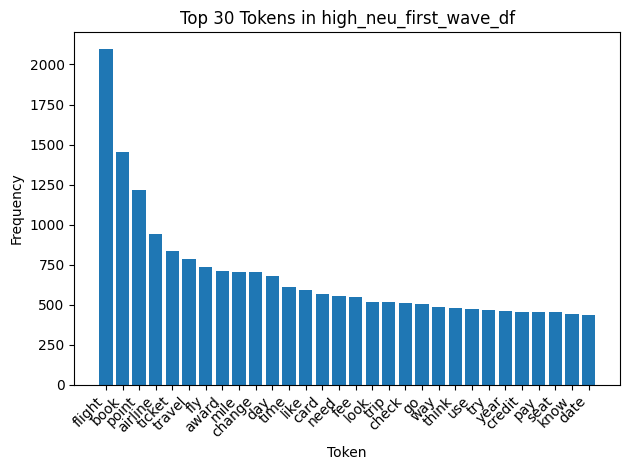

In [16]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Flatten your tokens into one long list
all_tokens = [t for toks in high_neu_first_wave_df['tokens'] for t in toks]

#  Build a frequency distribution
freq = Counter(all_tokens)
common = freq.most_common(30)   # top 30

#  Turn it into a DataFrame for easy inspection
df_freq = pd.DataFrame(common, columns=['token','count'])
print(df_freq)

# Plot a simple bar chart of the top tokens
tokens, counts = zip(*common)
plt.figure()
plt.bar(tokens, counts)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Token')
plt.ylabel('Frequency')
plt.title('Top 30 Tokens in high_neu_first_wave_df')
plt.tight_layout()
plt.show()

In [17]:
# Flatten all tokens into one list
all_words   = [word for tokens in high_neu_first_wave_df['tokens'] for word in tokens]

# Compute the length (in tokens) of each post
post_length = [len(tokens) for tokens in high_neu_first_wave_df['tokens']]

# Build the vocabulary
vocab       = sorted(set(all_words))

# Print your summary stats
print(f"{len(all_words)} words total, with a vocabulary size of {len(vocab)}")
print(f"Max reddit post length is {max(post_length)} tokens")
print(f"Mean reddit post length is {sum(post_length)/len(post_length):.2f} tokens")
print(f"Median reddit post length is {sorted(post_length)[len(post_length)//2]} tokens")


103201 words total, with a vocabulary size of 8585
Max reddit post length is 388 tokens
Mean reddit post length is 11.94 tokens
Median reddit post length is 9 tokens


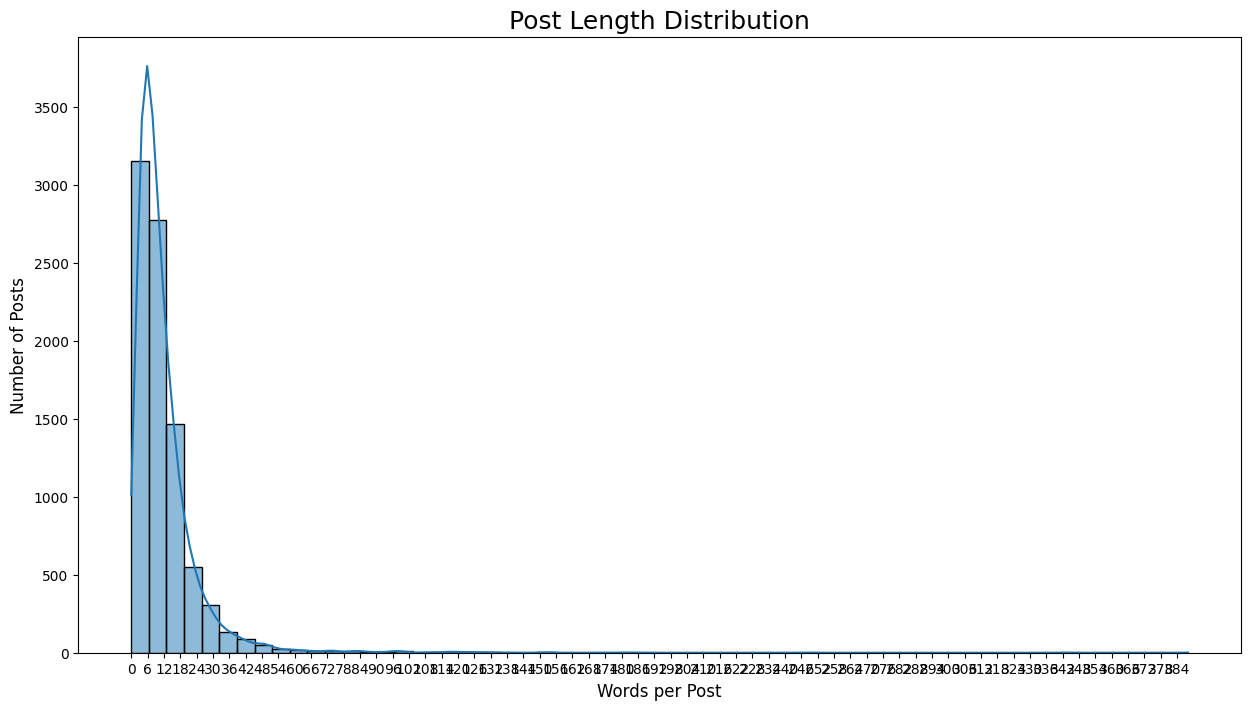

In [18]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)
plt.xticks(xticks)
plt.show()

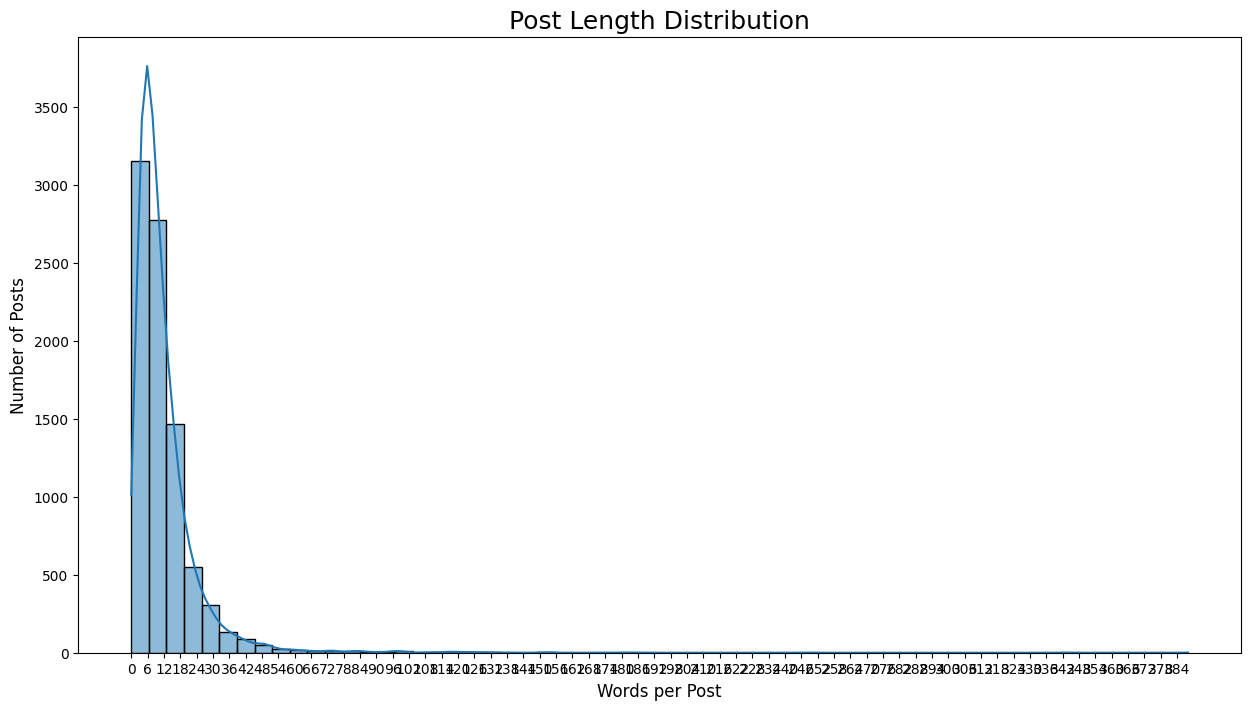

In [19]:
plt.figure(figsize=(15, 8))
sns.histplot(post_length, bins=60, kde=True)
plt.title('Post Length Distribution', fontsize=18)
plt.xlabel('Words per Post', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)
# Setting x-axis ticks and labels for more detail
max_length = max(post_length)
xticks = np.arange(0, max_length + 1, max_length // 60)
plt.xticks(xticks)
plt.show()

In [20]:
!pip install  gensim

# #1) Downgrade NumPy to 1.26.x
# !pip install numpy==1.26.0 --upgrade

# # 2) Force-reinstall Gensim so it compiles against the new NumPy
# !pip install --upgrade --force-reinstall gensim


  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.0 which is incompatible.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.7.0 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [21]:
import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# Prepare your list-of-lists from the `tokens` column
texts = high_neu_first_wave_df['tokens'].tolist()

# Train the bigram detector
bigram = Phrases(texts, min_count=3, threshold=60)
bigram_mod = Phraser(bigram)

# Train the trigram detector on the bigram-transformed texts
trigram = Phrases(bigram[texts], min_count=2, threshold=150)
trigram_mod = Phraser(trigram)

#  Apply bigram and trigram transforms
high_neu_first_wave_df['bigram_tokens']   = high_neu_first_wave_df['tokens'].apply(lambda doc: bigram_mod[doc])
high_neu_first_wave_df['trigram_tokens']  = high_neu_first_wave_df['tokens'].apply(lambda doc: trigram_mod[bigram_mod[doc]])

#
# high_neu_first_wave_df['bigram_text']   = high_neu_first_wave_df['bigram_tokens'].str.join(' ')
# high_neu_first_wave_df['trigram_text']  = high_neu_first_wave_df['trigram_tokens'].str.join(' ')

#  Inspect
print(high_neu_first_wave_df[['tokens','bigram_tokens','trigram_tokens']].head())


                                               tokens  \
5   [contradict, listing, fee, cancellation, page,...   
6   [wonder, suggest, american, ask, able, rebook,...   
9   [section, passenger, ticket, qualifying, refer...   
12  [look, like, removed, wording, travel, septemb...   
15  [day, available, flight, space, usually, confi...   

                                        bigram_tokens  \
5   [contradict, listing, fee, cancellation, page,...   
6   [wonder, suggest, american, ask, able, rebook,...   
9   [section, passenger, ticket, qualifying, refer...   
12  [look, like, removed, wording, travel, septemb...   
15  [day, available, flight, space, usually, confi...   

                                       trigram_tokens  
5   [contradict, listing, fee, cancellation, page,...  
6   [wonder, suggest, american, ask, able, rebook,...  
9   [section, passenger, ticket, qualifying, refer...  
12  [look, like, removed, wording, travel, septemb...  
15  [day, available, flight, space

In [22]:
#  Helper to detect n-grams in a token list
def contains_ngram(tokenized_list, n):
    return any(len(tok.split('_')) == n for tok in tokenized_list)

#  Flag rows
high_neu_first_wave_df['has_bigrams']  = high_neu_first_wave_df['bigram_tokens'].apply(lambda doc: contains_ngram(doc, 2))
high_neu_first_wave_df['has_trigrams'] = high_neu_first_wave_df['trigram_tokens'].apply(lambda doc: contains_ngram(doc, 3))

#  Count
rows_with_bigrams  = high_neu_first_wave_df['has_bigrams'].sum()
rows_with_trigrams = high_neu_first_wave_df['has_trigrams'].sum()
rows_with_none     = (~high_neu_first_wave_df['has_bigrams'] & ~high_neu_first_wave_df['has_trigrams']).sum()

#  Report
print(f"Rows with bigrams:   {rows_with_bigrams}")
print(f"Rows with trigrams:  {rows_with_trigrams}")
print(f"Rows with no n-grams: {rows_with_none}")


Rows with bigrams:   1765
Rows with trigrams:  50
Rows with no n-grams: 6879


In [23]:
high_neu_first_wave_df.head()

,created_utc,label,score,cleaned_text,tokens,final_text,bigram_tokens,trigram_tokens,has_bigrams,has_trigrams
5,2020-05-31,high neu,0.826023,seem contradict listing fee cancellation page ...,"[contradict, listing, fee, cancellation, page,...",contradict listing fee cancellation page refer...,"[contradict, listing, fee, cancellation, page,...","[contradict, listing, fee, cancellation, page,...",True,False
6,2020-05-31,high neu,0.867429,wondering well suggest call american ask thoug...,"[wonder, suggest, american, ask, able, rebook,...",wonder suggest american ask able rebook start ...,"[wonder, suggest, american, ask, able, rebook,...","[wonder, suggest, american, ask, able, rebook,...",False,False
9,2020-05-31,high neu,0.843736,section passenger ticket qualifying referring ...,"[section, passenger, ticket, qualifying, refer...",section passenger ticket qualifying refer auto...,"[section, passenger, ticket, qualifying, refer...","[section, passenger, ticket, qualifying, refer...",False,False
12,2020-05-31,high neu,0.897041,look like removed wording travel september th ...,"[look, like, removed, wording, travel, septemb...",look like removed wording travel september wai...,"[look, like, removed, wording, travel, septemb...","[look, like, removed, wording, travel, septemb...",False,False
15,2020-05-31,high neu,0.769651,doesnt day next available flight space usually...,"[day, available, flight, space, usually, confi...",day available flight space usually confirm per...,"[day, available, flight, space, usually, confi...","[day, available, flight, space, usually, confi...",False,False


In [24]:
# Print the total number of rows in the DataFrame
total_rows = high_neu_first_wave_df.shape[0]
print(f"Total number of rows in the DataFrame: {total_rows}")

# Check the number of rows in the 'trigram_tokenized' column
print(f"Number of rows in 'trigram_tokenized' column: {high_neu_first_wave_df['trigram_tokens'].shape[0]}")

Total number of rows in the DataFrame: 8644
Number of rows in 'trigram_tokenized' column: 8644


In [25]:
import itertools
from collections import Counter

# Flatten all trigram lists into one big sequence
all_trigrams = itertools.chain.from_iterable(high_neu_first_wave_df['trigram_tokens'])

#  Filter for genuine trigrams (exactly two underscores → three words joined)
trigram_counts = Counter(
    token for token in all_trigrams
    if isinstance(token, str) and token.count('_') == 2
)

#  How many unique trigrams?
total_unique_trigrams = len(trigram_counts)
print(f"Total number of unique trigrams: {total_unique_trigrams}")

#  Show the 10 most common trigrams
print("\nMost common trigrams:")
for trigram, count in trigram_counts.most_common(10):
    print(f"{trigram}: {count:,}")


Total number of unique trigrams: 19

Most common trigrams:
star_alliance_partner: 5
double_open_jaw: 5
air_tahiti_nui: 5
look_faq_posting: 5
klm_air_france: 4
west_coast_hawaii: 4
asia_pacific_region: 4
grand_hyatt_kauai: 4
single_open_jaw: 4
international_fare_component: 4


In [26]:
#import gensim.corpora as corpora
# Create Dictionary
#id2word = corpora.Dictionary(high_neu_first_wave_df['trigram_tokens'].tolist())

## pruning
#id2word.filter_extremes(no_below=5, no_above=0.5)

#    (Optional) Re-map the remaining token IDs to remove gaps
#id2word.compactify()

# 2. Convert each document to a Bag-of-Words
# texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# # Term Document Frequency
# corpus = [id2word.doc2bow(text) for text in texts]


# # View
# print(corpus[:1][0][:30])

In [27]:
# import gensim
# from gensim import corpora
# from gensim.models.ldamodel import LdaModel
# from nltk.tokenize import word_tokenize
# import nltk
# ## Build the basic LDA model
# lda_model = LdaModel(corpus=corpus,
#                                        id2word=id2word,
#                                        num_topics=3,
#                                        random_state=100,
#                                           chunksize=200,
#                                        passes=50,
#                                         iterations= 100,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)

In [28]:
# from pprint import pprint

# # Print the Keyword in the 3 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [29]:
high_neu_first_wave_df.head()

,created_utc,label,score,cleaned_text,tokens,final_text,bigram_tokens,trigram_tokens,has_bigrams,has_trigrams
5,2020-05-31,high neu,0.826023,seem contradict listing fee cancellation page ...,"[contradict, listing, fee, cancellation, page,...",contradict listing fee cancellation page refer...,"[contradict, listing, fee, cancellation, page,...","[contradict, listing, fee, cancellation, page,...",True,False
6,2020-05-31,high neu,0.867429,wondering well suggest call american ask thoug...,"[wonder, suggest, american, ask, able, rebook,...",wonder suggest american ask able rebook start ...,"[wonder, suggest, american, ask, able, rebook,...","[wonder, suggest, american, ask, able, rebook,...",False,False
9,2020-05-31,high neu,0.843736,section passenger ticket qualifying referring ...,"[section, passenger, ticket, qualifying, refer...",section passenger ticket qualifying refer auto...,"[section, passenger, ticket, qualifying, refer...","[section, passenger, ticket, qualifying, refer...",False,False
12,2020-05-31,high neu,0.897041,look like removed wording travel september th ...,"[look, like, removed, wording, travel, septemb...",look like removed wording travel september wai...,"[look, like, removed, wording, travel, septemb...","[look, like, removed, wording, travel, septemb...",False,False
15,2020-05-31,high neu,0.769651,doesnt day next available flight space usually...,"[day, available, flight, space, usually, confi...",day available flight space usually confirm per...,"[day, available, flight, space, usually, confi...","[day, available, flight, space, usually, confi...",False,False


In [30]:
# from gensim.models import CoherenceModel

# # Compute Coherence Score
# coherence_model_lda = CoherenceModel(model=lda_model, texts=high_neu_first_wave_df['trigram_tokenized'], dictionary=id2word, coherence='c_v')
# coherence_lda = coherence_model_lda.get_coherence()
# print('Coherence Score: ', coherence_lda)

In [31]:
# import pyLDAvis.gensim
# import pickle
# import pyLDAvis
# import pyLDAvis.gensim_models as gensimvis
# import pyLDAvis

# # Assuming ldamodel, corpus, and dictionary are already defined
# # Enable the automatic display of visualizations in Jupyter
# pyLDAvis.enable_notebook()

# # Prepare the LDA visualization directly
# LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# # Display the prepared visualization directly in the notebook
# pyLDAvis.display(LDAvis_prepared)

In [32]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools


texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# Create a Dictionary and Corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=seed,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()

     # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
seeds = [0, 1, 2]
num_topics_range = range(2, 10)  # Adjust the range based on your needs
chunksize_range = [1000]
passes_range = [100, 200,260]
iterations_range = [50,100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for seed in [0, 1, 2]:
 for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence , alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations, seed)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence,alpha,eta,seed))
    print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f} ,Alpha: {alpha}, Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta', 'seed'])
# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']
optimal_seed = optimal_result['seed']

print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")
print(f" seed:  {optimal_seed}")

Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.3468, Coherence: 0.5954 ,Alpha: [0.22884321 1.1616536 ], Eta: [4.31058    2.247038   1.7225705  ... 0.3835499  0.34431157 0.3442317 ]


Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.3452, Coherence: 0.6140 ,Alpha: [0.20669895 1.0853542 ], Eta: [4.412299   2.2465851  1.7600194  ... 0.38561738 0.34593084 0.3458795 ]


Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.3451, Coherence: 0.6140 ,Alpha: [0.20216674 1.0703408 ], Eta: [4.418822   2.243736   1.7656423  ... 0.38592276 0.34616524 0.34612003]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.3361, Coherence: 0.5706 ,Alpha: [0.15236309 0.88218576], Eta: [4.7640963  2.3535058  1.8939087  ... 0.39513475 0.35355374 0.3535484 ]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 100, Perplexity: -7.3356, Coherence: 0.5689 ,Alpha: [0.14813228 0.85619384], Eta: [4.9359736  2.3418388  1.901582   ... 0.39588034 0.35416085 0.354157  ]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 200, Perplexity: -7.3356, Coherence: 0.5689 ,Alpha: [0.14756927 0.85306424], Eta: [4.9462066  2.3398771  1.9025371  ... 0.39596343 0.35422838 0.35422462]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 50, Perplexity: -7.3336, Coherence: 0.5689 ,Alpha: [0.14293028 0.82731223], Eta: [5.0852623  2.4027393  1.9229559  ... 0.39821962 0.3560596  0.3560574 ]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 100, Perplexity: -7.3334, Coherence: 0.5689 ,Alpha: [0.14305837 0.8168371 ], Eta: [5.3586016  2.3903506  1.9245467  ... 0.3983807  0.3561918  0.35618955]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 200, Perplexity: -7.3334, Coherence: 0.5689 ,Alpha: [0.14288007 0.8151905 ], Eta: [5.3723216  2.3907602  1.9249952  ... 0.39842492 0.35622787 0.35622567]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.3612, Coherence: 0.5218 ,Alpha: [0.25142044 1.4396329  0.27950594], Eta: [0.9263724  0.4652554  0.5395624  ... 0.26059437 0.24642205 0.23847465]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.3578, Coherence: 0.4985 ,Alpha: [0.21710005 1.3427805  0.2337515 ], Eta: [0.98415834 0.47225022 0.55151165 ... 0.26397082 0.24019907 0.24015759]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.3568, Coherence: 0.5087 ,Alpha: [0.21247654 1.305161   0.2190272 ], Eta: [0.9613154  0.4731805  0.55220044 ... 0.2640722  0.24055679 0.24052368]
Num Topics: 3, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.3562, Coherence: 0.5160 ,Alpha: [0.24276768 1.39

Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.3358, Coherence: 0.5474 ,Alpha: [0.9009419  0.12515514], Eta: [9.251009   1.6676893  0.61540216 ... 0.39751908 0.35554612 0.3555469 ]


Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.3353, Coherence: 0.5520 ,Alpha: [0.8790794  0.12470829], Eta: [9.277698   1.6692258  0.6158093  ... 0.39773628 0.35572433 0.35572523]


Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.3351, Coherence: 0.5520 ,Alpha: [0.8735     0.12442762], Eta: [9.285989   1.6703372  0.6160298  ... 0.39784724 0.3558153  0.35581622]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.3295, Coherence: 0.5542 ,Alpha: [0.80824286 0.11443743], Eta: [10.025057    1.7117438   0.625136   ...  0.40362865  0.36048096
  0.36048248]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 100, Perplexity: -7.3288, Coherence: 0.5542 ,Alpha: [0.78279465 0.11380203], Eta: [10.072796    1.7162464   0.62608653 ...  0.40410912  0.36087433
  0.36087587]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 200, Perplexity: -7.3288, Coherence: 0.5542 ,Alpha: [0.7867216  0.11433711], Eta: [10.024752    1.7136521   0.6254861  ...  0.40382636  0.36064333
  0.36064485]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 50, Perplexity: -7.3277, Coherence: 0.5445 ,Alpha: [0.77887374 0.11097115], Eta: [10.234731    1.7256913   0.6283217  ...  0.40553182  0.3620234
  0.36202502]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 100, Perplexity: -7.3269, Coherence: 0.5344 ,Alpha: [0.7544953  0.11042577], Eta: [10.297648    1.7323991   0.62966496 ...  0.40620345  0.36257267
  0.3625743 ]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 200, Perplexity: -7.3269, Coherence: 0.5445 ,Alpha: [0.75815827 0.11081062], Eta: [10.250451    1.7298818   0.6290893  ...  0.4059324   0.36235133
  0.36235294]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.3877, Coherence: 0.5283 ,Alpha: [1.3803272 0.2147874 1.261819 ], Eta: [1.0127797  0.45302203 0.3200848  ... 0.25744742 0.24393302 0.2364043 ]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.3875, Coherence: 0.5173 ,Alpha: [1.3058428 0.2207983 1.2939492], Eta: [0.99894345 0.45268282 0.31368575 ... 0.25532    0.24756606 0.23679675]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.3879, Coherence: 0.5240 ,Alpha: [1.1939678  0.22979645 1.4000978 ], Eta: [0.9905141  0.45480844 0.31128687 ... 0.24941587 0.24755584 0.23605938]
Num Topics: 3, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.3819, Coherence: 0.5223 ,Alpha: [1.3242491  0.2

Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.3477, Coherence: 0.4815 ,Alpha: [0.21555732 1.221731  ], Eta: [5.398047   1.751636   1.7908537  ... 0.38228822 0.34320307 0.34313768]


Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.3469, Coherence: 0.5240 ,Alpha: [0.19701517 1.1721511 ], Eta: [4.797009   1.8098736  1.8119261  ... 0.38418767 0.3447095  0.34466937]


Num Topics: 2, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.3435, Coherence: 0.5676 ,Alpha: [0.16677703 1.0875738 ], Eta: [3.232004   1.9208554  1.8334908  ... 0.38739663 0.34728447 0.3472701 ]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.3422, Coherence: 0.5003 ,Alpha: [0.20067379 1.1346842 ], Eta: [5.68646    1.7866418  1.8264525  ... 0.3863676  0.3464366  0.34639862]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 100, Perplexity: -7.3396, Coherence: 0.5565 ,Alpha: [0.16761588 1.0313679 ], Eta: [4.44143    1.9123185  1.8691499  ... 0.3907449  0.34996808 0.34995615]


Num Topics: 2, Chunksize: 1000, Passes: 200, Iterations: 200, Perplexity: -7.3367, Coherence: 0.6051 ,Alpha: [0.14464921 0.95299846], Eta: [3.63114    2.029466   1.8681818  ... 0.39273393 0.3515752  0.35157225]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 50, Perplexity: -7.3406, Coherence: 0.5003 ,Alpha: [0.19742966 1.1032525 ], Eta: [5.8416233  1.7995609  1.8378242  ... 0.38765386 0.3474698  0.34743708]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 100, Perplexity: -7.3362, Coherence: 0.5814 ,Alpha: [0.1522743 0.9698659], Eta: [4.142607   1.9828864  1.8982834  ... 0.39375952 0.3524108  0.35240543]


Num Topics: 2, Chunksize: 1000, Passes: 260, Iterations: 200, Perplexity: -7.3350, Coherence: 0.6051 ,Alpha: [0.14216535 0.92814016], Eta: [3.812573   2.050415   1.8797988  ... 0.39421976 0.35277954 0.35277724]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 50, Perplexity: -7.3599, Coherence: 0.5404 ,Alpha: [0.16234092 0.24497955 1.4830434 ], Eta: [0.47091115 0.48242974 0.56352884 ... 0.27135453 0.2444195  0.24438654]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 100, Perplexity: -7.3606, Coherence: 0.5225 ,Alpha: [0.15107533 0.23205732 1.447501  ], Eta: [0.4707348  0.4846741  0.56799036 ... 0.26915148 0.25393322 0.2454737 ]
Num Topics: 3, Chunksize: 1000, Passes: 100, Iterations: 200, Perplexity: -7.3599, Coherence: 0.5199 ,Alpha: [0.15940228 0.22502933 1.4418359 ], Eta: [0.48561728 0.48358044 0.5675563  ... 0.27259937 0.2539644  0.245218  ]
Num Topics: 3, Chunksize: 1000, Passes: 200, Iterations: 50, Perplexity: -7.3533, Coherence: 0.5404 ,Alpha: [0.15272819 0.22

In [33]:
# 1. Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = optimal_seed,
    per_word_topics=True
)

# 2. Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


Re-fitted Optimal Model:
 Coherence: 0.6140
 Perplexity: -7.3451
 Alpha (per topic): [0.20216674 1.0703408 ]
 Eta   (per word):  [4.418822   2.243736   1.7656423  ... 0.38592276 0.34616524 0.34612003]


In [34]:
lda_opt.save('/content/drive/MyDrive/lda_model_neutral_1st_wave.gensim')


In [35]:
import numpy as np
from google.colab import files

#
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

# 2. Write them into a single text file
with open('lda_model_full_summary.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")

# 3. Trigger the download
files.download('lda_model_full_summary.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
#  verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


Alpha match: True
Eta   match: True


In [37]:
# : Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

#  Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



=== Topics ===
[(0,
  '0.030*"point" + 0.025*"card" + 0.021*"credit" + 0.016*"night" + '
  '0.013*"hotel" + 0.011*"cash" + 0.011*"status" + 0.009*"year" + 0.009*"stay" '
  '+ 0.008*"chase"'),
 (1,
  '0.025*"flight" + 0.015*"book" + 0.013*"airline" + 0.010*"ticket" + '
  '0.009*"fly" + 0.008*"travel" + 0.008*"change" + 0.008*"day" + 0.007*"time" '
  '+ 0.007*"mile"')]

Sample doc-topic distribution for doc 0:
[(0, 0.052350648), (1, 0.94764936)]


In [38]:
#  pyLDAvis visualization

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [39]:
#  Print the top 30 terms per topic
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  point (0.0304)
  card (0.0249)
  credit (0.0212)
  night (0.0157)
  hotel (0.0132)
  cash (0.0110)
  status (0.0106)
  year (0.0095)
  stay (0.0088)
  chase (0.0085)
  pay (0.0081)
  use (0.0077)
  room (0.0077)
  hyatt (0.0071)
  hilton (0.0063)
  account (0.0062)
  amex (0.0060)
  marriott (0.0058)
  rate (0.0057)
  earn (0.0056)
  insurance (0.0047)
  voucher (0.0047)
  resort (0.0042)
  member (0.0041)
  gold (0.0041)
  csr (0.0039)
  spend (0.0039)
  portal (0.0038)
  upgrade (0.0038)
  get (0.0036)

Topic 2:
  flight (0.0254)
  book (0.0155)
  airline (0.0127)
  ticket (0.0103)
  fly (0.0091)
  travel (0.0083)
  change (0.0077)
  day (0.0076)
  time (0.0071)
  mile (0.0068)
  award (0.0065)
  check (0.0064)
  need (0.0061)
  look (0.0057)
  like (0.0057)
  go (0.0056)
  way (0.0053)
  seat (0.0053)
  know (0.0051)
  try (0.0051)
  think (0.0051)
  refund (0.0050)
  point (0.0047)
  fee (0.0046)
  united (0.0044)
  trip (0.0044)
  date (0

In [40]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(high_neu_first_wave_df['trigram_tokens'].tolist())

## pruning
id2word.filter_extremes(no_below=5, no_above=0.7)

#
id2word.compactify()

# 2. Convert each document to a Bag-of-Words
texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# # Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]


# # View
print(corpus[:1][0][:30])

[(0, 2), (1, 1), (2, 1), (3, 2), (4, 2), (5, 1), (6, 1), (7, 1), (8, 7), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 2), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 2), (23, 2), (24, 3), (25, 1)]


In [41]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
import pandas as pd
import numpy as np
import itertools


# Create a Dictionary and Corpus
dictionary = id2word


# Function to compute coherence and perplexity
def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations):
    lda_model = LdaModel(corpus=corpus,
                         id2word=dictionary,
                         num_topics=num_topics,
                         random_state=100,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         alpha='auto',
                         eta='auto',
                         per_word_topics=True)

    perplexity = lda_model.log_perplexity(corpus)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()

     # Extract alpha and eta
    alpha = lda_model.alpha
    eta = lda_model.eta
    return perplexity, coherence, alpha, eta

# Define the parameter grid with your specific values
num_topics_range = range(2, 10)  # Adjust the range based on your needs
chunksize_range = [250]
passes_range = [100, 200,260]
iterations_range = [50,100, 200]

# Store results
results = []

# Grid search over all combinations of hyperparameters
for num_topics, chunksize, passes, iterations in itertools.product(num_topics_range, chunksize_range, passes_range, iterations_range):
    perplexity, coherence , alpha, eta = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics, chunksize, passes, iterations)
    results.append((num_topics, chunksize, passes, iterations, perplexity, coherence,alpha,eta))
    print(f"Num Topics: {num_topics}, Chunksize: {chunksize}, Passes: {passes}, Iterations: {iterations}, Perplexity: {perplexity:.4f}, Coherence: {coherence:.4f} ,Alpha: {alpha}, Eta: {eta}")

# Convert results to a DataFrame for better analysis
results_df = pd.DataFrame(results, columns=['num_topics', 'chunksize', 'passes', 'iterations', 'perplexity', 'coherence','alpha','eta'])
# Add exponentiated perplexity column
results_df['perplexity_exp'] = np.exp(-results_df['perplexity'])

# Display results
print("\nResults:")
print(results_df)

# Find the optimal number of topics with the highest coherence
optimal_result = results_df.sort_values(
    by=['coherence', 'perplexity_exp'],
    ascending=[False, True]
).iloc[0]
optimal_num_topics = optimal_result['num_topics']
optimal_chunksize = optimal_result['chunksize']
optimal_passes = optimal_result['passes']
optimal_iterations = optimal_result['iterations']
optimal_perplexity = optimal_result['perplexity_exp']
optimal_coherence = optimal_result['coherence']
optimal_alpha = optimal_result['alpha']
optimal_eta   = optimal_result['eta']

print(f"\nOptimal Parameters:")
print(f"Number of Topics: {optimal_num_topics}")
print(f"Chunksize: {optimal_chunksize}")
print(f"Passes: {optimal_passes}")
print(f"Iterations: {optimal_iterations}")
print(f"Coherence: {optimal_coherence:.4f}")
print(f"Perplexity: {optimal_perplexity:.4f}")
print(f" Alpha (per topic): {optimal_alpha}")
print(f" Eta   (per word):  {optimal_eta}")

Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 50, Perplexity: -6.7103, Coherence: 0.5592 ,Alpha: [0.9064921 1.8234454], Eta: [0.7389576  7.2853208  0.5207353  ... 0.2926301  0.27059302 0.29036176]


Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 100, Perplexity: -6.7103, Coherence: 0.5592 ,Alpha: [0.90617824 1.8225915 ], Eta: [0.73857033 7.290338   0.5215029  ... 0.29263884 0.27060744 0.29026997]


Num Topics: 2, Chunksize: 250, Passes: 100, Iterations: 200, Perplexity: -6.7103, Coherence: 0.5592 ,Alpha: [0.90540546 1.8199973 ], Eta: [0.73756325 7.3002605  0.52160996 ... 0.29267922 0.2706495  0.2903749 ]


Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 50, Perplexity: -6.6945, Coherence: 0.5528 ,Alpha: [0.8534707 1.7511069], Eta: [0.7816961  7.879584   0.59817374 ... 0.29349458 0.27598992 0.29419863]


Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 100, Perplexity: -6.6945, Coherence: 0.5528 ,Alpha: [0.8534124 1.751127 ], Eta: [0.7816724  7.8795724  0.5982368  ... 0.2934956  0.27599126 0.2941933 ]


Num Topics: 2, Chunksize: 250, Passes: 200, Iterations: 200, Perplexity: -6.6945, Coherence: 0.5528 ,Alpha: [0.8512752 1.7523904], Eta: [0.7804273  7.885208   0.59860647 ... 0.29350993 0.27599913 0.29406163]


Num Topics: 2, Chunksize: 250, Passes: 260, Iterations: 50, Perplexity: -6.6900, Coherence: 0.5482 ,Alpha: [0.8417362 1.7192755], Eta: [0.79795086 8.051413   0.61616147 ... 0.29458275 0.27808183 0.29659036]


Num Topics: 2, Chunksize: 250, Passes: 260, Iterations: 100, Perplexity: -6.6900, Coherence: 0.5482 ,Alpha: [0.8417319 1.7192826], Eta: [0.7979525  8.051389   0.61616504 ... 0.2945827  0.27808177 0.2965891 ]


Num Topics: 2, Chunksize: 250, Passes: 260, Iterations: 200, Perplexity: -6.6901, Coherence: 0.5482 ,Alpha: [0.8387292 1.7230307], Eta: [0.79583186 8.055321   0.6171673  ... 0.29460132 0.27807072 0.29633135]


Num Topics: 3, Chunksize: 250, Passes: 100, Iterations: 50, Perplexity: -6.7345, Coherence: 0.5465 ,Alpha: [1.6699765 2.2403972 1.6042067], Eta: [0.25591415 0.2827107  0.22082688 ... 0.19801469 0.19073676 0.20381315]


Num Topics: 3, Chunksize: 250, Passes: 100, Iterations: 100, Perplexity: -6.7367, Coherence: 0.5306 ,Alpha: [2.0369122 2.1698253 1.6074247], Eta: [0.257268   0.2812224  0.22107677 ... 0.19743352 0.19336572 0.2279716 ]


Num Topics: 3, Chunksize: 250, Passes: 100, Iterations: 200, Perplexity: -6.7421, Coherence: 0.5148 ,Alpha: [2.158609  2.3846827 1.7201339], Eta: [0.25620115 0.28144872 0.21893893 ... 0.198445   0.19252805 0.20365505]


Num Topics: 3, Chunksize: 250, Passes: 200, Iterations: 50, Perplexity: -6.7172, Coherence: 0.5612 ,Alpha: [1.6362597 2.1835794 1.6015323], Eta: [0.25558925 0.2854278  0.22280122 ... 0.19524391 0.1889095  0.20130438]


Num Topics: 3, Chunksize: 250, Passes: 200, Iterations: 100, Perplexity: -6.7193, Coherence: 0.5507 ,Alpha: [2.0200171 2.1177804 1.5966297], Eta: [0.2575727  0.28412357 0.22318424 ... 0.19432078 0.19123472 0.20923667]


Num Topics: 3, Chunksize: 250, Passes: 200, Iterations: 200, Perplexity: -6.7250, Coherence: 0.5332 ,Alpha: [2.130701  2.34824   1.7157823], Eta: [0.2557624  0.28392917 0.22059242 ... 0.1950349  0.1913527  0.20099258]


Num Topics: 3, Chunksize: 250, Passes: 260, Iterations: 50, Perplexity: -6.7124, Coherence: 0.5685 ,Alpha: [1.6323497 2.1692438 1.6054955], Eta: [0.25556433 0.28593138 0.22328447 ... 0.19492248 0.18875875 0.20099618]


Num Topics: 3, Chunksize: 250, Passes: 260, Iterations: 100, Perplexity: -6.7140, Coherence: 0.5507 ,Alpha: [2.0010586 2.0878482 1.5874746], Eta: [0.25754237 0.2845958  0.22385544 ... 0.19387949 0.19104527 0.2087191 ]


Num Topics: 3, Chunksize: 250, Passes: 260, Iterations: 200, Perplexity: -6.7200, Coherence: 0.5516 ,Alpha: [2.1198835 2.3311143 1.7055485], Eta: [0.25562036 0.28460473 0.22100843 ... 0.1945854  0.19150582 0.2007311 ]


Num Topics: 4, Chunksize: 250, Passes: 100, Iterations: 50, Perplexity: -6.7570, Coherence: 0.4841 ,Alpha: [1.6025329 2.65137   1.9369704 3.3434052], Eta: [0.18294413 0.19072205 0.16736977 ... 0.15839939 0.15591545 0.15664726]


Num Topics: 4, Chunksize: 250, Passes: 100, Iterations: 100, Perplexity: -6.7654, Coherence: 0.5003 ,Alpha: [2.2145007 2.724312  2.0000732 3.6046164], Eta: [0.1822517  0.19060822 0.1696832  ... 0.15828867 0.15533452 0.15752168]


Num Topics: 4, Chunksize: 250, Passes: 100, Iterations: 200, Perplexity: -6.7659, Coherence: 0.5181 ,Alpha: [2.1917024 2.6617293 2.0776646 3.5981085], Eta: [0.18206166 0.19053595 0.16901098 ... 0.15828241 0.15510213 0.15775962]


Num Topics: 4, Chunksize: 250, Passes: 200, Iterations: 50, Perplexity: -6.7405, Coherence: 0.5056 ,Alpha: [1.6006725 2.6176133 1.9166944 3.3191717], Eta: [0.18281163 0.1916308  0.16822428 ... 0.1567511  0.15494432 0.15631224]


Num Topics: 4, Chunksize: 250, Passes: 200, Iterations: 100, Perplexity: -6.7489, Coherence: 0.5063 ,Alpha: [2.2083633 2.7015746 1.9828988 3.5980737], Eta: [0.18227059 0.1915264  0.17059202 ... 0.15667345 0.15460064 0.15677656]


Num Topics: 4, Chunksize: 250, Passes: 200, Iterations: 200, Perplexity: -6.7494, Coherence: 0.5153 ,Alpha: [2.185521  2.6408184 2.0590138 3.5912461], Eta: [0.1820737  0.19144692 0.16981287 ... 0.15665364 0.15440042 0.15701316]


Num Topics: 4, Chunksize: 250, Passes: 260, Iterations: 50, Perplexity: -6.7358, Coherence: 0.5152 ,Alpha: [1.5994359 2.6039402 1.908739  3.309241 ], Eta: [0.18276656 0.19183108 0.16841146 ... 0.15657428 0.15492569 0.15645893]


Num Topics: 4, Chunksize: 250, Passes: 260, Iterations: 100, Perplexity: -6.7442, Coherence: 0.4998 ,Alpha: [2.2060783 2.693644  1.9764905 3.596487 ], Eta: [0.1822711  0.19173463 0.17078075 ... 0.15650827 0.15463069 0.1568402 ]
Num Topics: 4, Chunksize: 250, Passes: 260, Iterations: 200, Perplexity: -6.7447, Coherence: 0.5153 ,Alpha: [2.1822567 2.6321135 2.0515056 3.588954 ], Eta: [0.18206775 0.19165236 0.16995321 ... 0.15648381 0.15443054 0.15707767]
Num Topics: 5, Chunksize: 250, Passes: 100, Iterations: 50, Perplexity: -6.7712, Coherence: 0.4935 ,Alpha: [2.1051943 3.3597162 2.4802206 3.3085842 1.1342138], Eta: [0.14760153 0.15184124 0.13878188 ... 0.13345283 0.13196655 0.13350827]
Num Topics: 5, Chunksize: 250, Passes: 100, Iterations: 100, Perplexity: -6.7747, Coherence: 0.4883 ,Alpha: [2.247456  3.263065  3.0377736 3.1929326 1.4794325], Eta: [0.14677684 0.15110041 0.13866235 ... 0.13301574 0.13199104 0.13283129]
Num Topics: 5, Chunksize: 250, Passes: 100, Iterations: 200, Perplexi

In [42]:
# 1. Fit the model
lda_opt = LdaModel(
    corpus        = corpus,
    id2word       = dictionary,
    num_topics    = optimal_num_topics,
    chunksize     = optimal_chunksize,
    passes        = optimal_passes,
    iterations    = optimal_iterations,
    alpha         = 'auto',
    eta           = 'auto',
    random_state  = 100,
    per_word_topics=True
)

# 2. Extract metrics and priors
opt_perp  = lda_opt.log_perplexity(corpus)
opt_coh   = CoherenceModel(model=lda_opt, texts=texts, dictionary=dictionary, coherence='c_v').get_coherence()
opt_alpha = lda_opt.alpha
opt_eta   = lda_opt.eta

print(f"Re-fitted Optimal Model:")
print(f" Coherence: {opt_coh:.4f}")
print(f" Perplexity: {opt_perp:.4f}")
print(f" Alpha (per topic): {opt_alpha}")
print(f" Eta   (per word):  {opt_eta}")


Re-fitted Optimal Model:
 Coherence: 0.5685
 Perplexity: -6.7124
 Alpha (per topic): [1.6323497 2.1692438 1.6054955]
 Eta   (per word):  [0.25556433 0.28593138 0.22328447 ... 0.19492248 0.18875875 0.20099618]


In [43]:
import numpy as np
from google.colab import files

# 1.
coherence_val  = opt_coh
perplexity_val = opt_perp
alpha_val      = opt_alpha
eta_vals       = opt_eta  # full array

# 2.
with open('lda_model_full_summary.txt', 'w') as f:
    f.write("Re-fitted Optimal Model:\n")
    f.write(f" Coherence:  {coherence_val:.4f}\n")
    f.write(f" Perplexity: {perplexity_val:.4f}\n")
    f.write(f" Alpha:      {alpha_val}\n")
    f.write(" Eta values:\n")
    for eta in eta_vals:
        f.write(f"{eta}\n")

# 3.
files.download('lda_model_full_summary.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
# : verify that the refit recovered the same priors
import numpy as np

print("Alpha match:", np.allclose(optimal_alpha, opt_alpha))
print("Eta   match:", np.allclose(optimal_eta,   opt_eta))


Alpha match: True
Eta   match: True


In [45]:
#  Imports
from pprint import pprint
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

#  Print topics & sample document–topic distribution
print("=== Topics ===")
pprint(lda_opt.print_topics())

doc_topics = [lda_opt.get_document_topics(doc) for doc in corpus]
print("\nSample doc-topic distribution for doc 0:")
pprint(doc_topics[0])



=== Topics ===
[(0,
  '0.029*"travel" + 0.024*"change" + 0.024*"ticket" + 0.018*"card" + '
  '0.018*"refund" + 0.017*"credit" + 0.016*"pay" + 0.014*"airline" + '
  '0.013*"fee" + 0.013*"try"'),
 (1,
  '0.062*"flight" + 0.029*"book" + 0.023*"fly" + 0.022*"airline" + '
  '0.016*"check" + 0.014*"mile" + 0.013*"look" + 0.013*"award" + 0.012*"seat" '
  '+ 0.012*"way"'),
 (2,
  '0.035*"point" + 0.019*"go" + 0.018*"day" + 0.017*"use" + 0.017*"think" + '
  '0.015*"year" + 0.015*"time" + 0.014*"trip" + 0.014*"know" + 0.013*"week"')]

Sample doc-topic distribution for doc 0:
[(0, 0.59329593), (1, 0.09339765), (2, 0.31330642)]


In [46]:
# : pyLDAvis visualization

pyLDAvis.enable_notebook()
vis_data = gensimvis.prepare(lda_opt, corpus, dictionary)
pyLDAvis.display(vis_data)


In [47]:
# Print the top 30 terms per topic
print("\n=== Top 30 terms per topic ===")
for topic_id, term_weights in lda_opt.show_topics(
        num_topics=lda_opt.num_topics,
        num_words=30,
        formatted=False):
    print(f"Topic {topic_id + 1}:")
    for word, weight in term_weights:
        print(f"  {word} ({weight:.4f})")
    print()



=== Top 30 terms per topic ===
Topic 1:
  travel (0.0290)
  change (0.0245)
  ticket (0.0237)
  card (0.0184)
  refund (0.0177)
  credit (0.0165)
  pay (0.0156)
  airline (0.0145)
  fee (0.0133)
  try (0.0132)
  need (0.0120)
  ask (0.0113)
  say (0.0100)
  number (0.0096)
  yes (0.0093)
  cancel (0.0091)
  hotel (0.0089)
  new (0.0086)
  cash (0.0078)
  account (0.0075)
  issue (0.0075)
  apply (0.0075)
  date (0.0074)
  status (0.0073)
  offer (0.0071)
  charge (0.0071)
  thank (0.0071)
  free (0.0071)
  book (0.0070)
  purchase (0.0066)

Topic 2:
  flight (0.0619)
  book (0.0287)
  fly (0.0227)
  airline (0.0222)
  check (0.0156)
  mile (0.0136)
  look (0.0135)
  award (0.0127)
  seat (0.0123)
  way (0.0122)
  airport (0.0098)
  united (0.0097)
  fare (0.0096)
  price (0.0095)
  delta (0.0091)
  find (0.0090)
  hour (0.0085)
  ticket (0.0080)
  transfer (0.0077)
  route (0.0075)
  availability (0.0074)
  need (0.0073)
  option (0.0071)
  available (0.0071)
  want (0.0071)
  differe

In [48]:
# ## FIND THE OPTIMAL TOPIC

# import gensim
# from gensim import corpora
# from gensim.models import LdaModel
# from gensim.models.coherencemodel import CoherenceModel
# import pandas as pd

#
# texts = high_neu_first_wave_df['trigram_tokens'].tolist()

# # Create a Dictionary and Corpus
# dictionary = corpora.Dictionary(texts)
# corpus = [dictionary.doc2bow(text) for text in texts]

# # Function to compute coherence and perplexity
# def compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics):
#     lda_model = LdaModel(corpus=corpus,
#                                        id2word=dictionary,
#                                        num_topics=num_topics,
#                                        random_state=100,
#                                           chunksize=200,
#                                        passes=50,
#                                         iterations= 100,
#                                        alpha='auto',
#                                       eta='auto',
#                                        per_word_topics=True)
#     perplexity = lda_model.log_perplexity(corpus)
#     coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
#     coherence = coherence_model_lda.get_coherence()
#     return perplexity, coherence

# # Testing different numbers of topics
# results = []
# for num_topics in range(2, 12):  # You can adjust the range based on your needs
#     perplexity, coherence = compute_coherence_and_perplexity(corpus, dictionary, texts, num_topics)
#     results.append((num_topics, perplexity, coherence))

# # Display results
# print("Num Topics | Perplexity | Coherence")
# for result in results:
#     print(f"{result[0]:10d} | {result[1]:10.4f} | {result[2]:10.4f}")

# # Optional: find the number of topics with the highest coherence
# optimal_num_topics = sorted(results, key=lambda x: x[2], reverse=True)[0][0]
# print(f"Optimal Number of Topics: {optimal_num_topics}")


In [49]:
# # Extracting and printing the top 30 salient terms for each topic
# num_topics = lda_model.num_topics
# num_words = 30

# for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
#     print(f"Topic {idx + 1}:")
#     for word, weight in topic:
#         print(f"  {word} ({weight:.4f})")
#     print()